This code was mostly using this guide as reference https://gist.github.com/analyticsindiamagazine/97f53c3a6ee5f63efea92e4159792f92#file-predicting_news_category_with_bert_in_tensorflow-ipynb

In [ ]:
%tensorflow_version 1.0.1

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.0.1`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.


In [ ]:
!pip install bert-tensorflow==1.0.1

     |████████████████████████████████| 67 kB 2.1 MB/s 


In [ ]:
import tensorflow as tf
print(tf.__version__)

1.15.2


In [ ]:
import pandas as pd
import tensorflow_hub as hub
from datetime import datetime
from sklearn.model_selection import train_test_split
import os

print("tensorflow version : ", tf.__version__)
print("tensorflow_hub version : ", hub.__version__)

tensorflow version :  1.15.2
tensorflow_hub version :  0.12.0


In [ ]:
#Importing BERT modules
import bert
from bert import run_classifier
from bert import optimization
from bert import tokenization


In [ ]:
from google.colab import drive
drive.mount("/GD")

Mounted at /GD


In [ ]:
# Set the output directory for saving model file
OUTPUT_DIR = '/GD/My Drive/Colab Notebooks/BERT/bert_rating_category'

#@markdown Whether or not to clear/delete the directory and create a new one
DO_DELETE = False #@param {type:"boolean"}

if DO_DELETE:
  try:
    tf.gfile.DeleteRecursively(OUTPUT_DIR)
  except:
    pass

tf.gfile.MakeDirs(OUTPUT_DIR)
print('***** Model output directory: {} *****'.format(OUTPUT_DIR))

***** Model output directory: /GD/My Drive/Colab Notebooks/BERT/bert_rating_category *****


Loading The Data

We will now load the data from a Google Drive directory and will also split the training set in to training and validation sets.

In [ ]:
import pandas as pd

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving rating_test.csv to rating_test.csv


In [ ]:
import io
# df2 = pd.read_csv(io.BytesIO(uploaded['rating.csv']))

In [ ]:
df3 = pd.read_csv(io.BytesIO(uploaded['rating_test.csv']))
df3

,work_id,title,author,rating,category,fandom,relationship,character,additional tags,language,...,status date,words,chapters,comments,kudos,bookmarks,hits,all_kudos,all_bookmarks,body
0,35867929,The Call of Fate,['EmpressOfTheFlame'],Explicit,"F/M, M/M, Multi",HELIOS Rising Heroes (Video Game),"Jay Kidman/Reader, Various/Reader, Dino Albani...","Reader, You, Jay Kidman, Dino Albani, Akira Ot...","First Time, Praise Kink, Smut, Romance, Reader...",English,...,2022-04-19,10191,15/?,1.0,13.0,1.0,455,['APH_Wonderland'],[],It would be accurate to say that Jay had been ...
1,34628254,Sacrifice,['Thewonderfulwiccan'],Explicit,Multi,"Young Justice (Cartoon), Young Justice - All M...",Dick Grayson/Wally West,"Dick Grayson, Wally West, Barbara Gordon, M'ga...","Heavy Angst, Human Trafficking, Emotional Hurt...",English,...,2022-04-19,51697,17/?,39.0,208.0,42.0,5721,"['herbalwigeon', 'spekkoekenak', 'NightBek', '...",[],They'd scream. \n\nThey'd cry. \n\nBeg to go h...
2,38261965,Sick Leave,['Hemaris_diffinis'],Teen And Up Audiences,Gen,The Owl House (Cartoon),Eda Clawthorne/Raine Whispers,"Raine Whispers, Terra Snapdragon, Eda Clawthorne",Amber Derwin and Kayta are mentioned but not p...,English,...,2022-04-19,7439,5/?,10.0,56.0,4.0,678,"['goblingorg', 'Dantsem', 'sapphicsoup', 'imlo...",[],"Ok, ok, I need to calm down and make a plan, R..."
3,38475940,Qing Dian Bu Da Yang,['notthechosenone'],Teen And Up Audiences,Gen,Xin Shi Jie Kuang Huan |NU: carnival (Video Game),"Aster/Eiden (NU: carnival), Kuya/Quincy (NU: c...","Eiden (NU: carnival), Yakumo (NU: carnival), A...",NaN,Zhong Wen -Pu Tong Hua Guo Yu,...,2022-04-19,10241,7/7,NaN,NaN,NaN,7,[],[],\nKun Xi Yi Zhi Du Gei Ren Bi Jiao topDe Fen W...
4,38125645,"absence, hearts",['Marmeladeskies'],Explicit,M/M,Formula 1 RPF,Lando Norris/Max Verstappen/Daniel Ricciardo/C...,"Lando Norris, Michael Italiano, Charles Lecler...","Alpha/Beta/Omega Dynamics, Omegaverse, Pack Dy...",English,...,2022-04-19,37314,21/27,625.0,512.0,41.0,18354,"['nonotwithoutyou', 'OneAccount', 'loveisme', ...",[],\n (See the end of the chapter for n...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,242,Room to Breathe (Air to Breathe Stop Motion Ov...,['WitchQueen (zvi)'],Not Rated,M/M,The Sentinel,Jim Ellison/Blair Sandburg,"Jim Ellison, Blair Sandburg","post-episode, post-SenToo, Remix, Angst",English,...,2003-03-27,2835,1/1,NaN,11.0,NaN,694,"['EllowynTheNotKing', 'Castianamicheals', 'Cor...",[],"He'd been sleeping for days, weeks now. In Sie..."
196,243,Life After,['velocitygrass'],Explicit,M/M,Stargate Atlantis,John Sheppard/Rodney McKay,"John Sheppard, Rodney McKay","Earth destroyed, SGA Big Bang 2008, Suicide, S...",English,...,2008-09-17,48260,1/1,22.0,286.0,103.0,8367,"['Zzickle', 'Emilise284', 'Madam_Vu', 'prollpe...",[],Prologue:\n\nCharlie Mayer's life began when h...
197,244,In which there is much disparagement of Sean C...,['WitchQueen (zvi)'],Not Rated,Other,NSYNC,NaN,"Justin Timberlake, Chris Kirkpatrick, Joey Fat...","Popslash - Freeform, Remixed",English,...,2002-07-07,1404,1/1,NaN,2.0,1.0,346,['crimisin'],[],Justin was the last one in the hotel. He'd bee...
198,245,Not Angry Anymore,['zvi'],Not Rated,Gen,The Sentinel,NaN,Darryl Banks,"Angst, Character of Color",English,...,2004-09-19,807,1/1,NaN,11.0,NaN,425,"['BrynPlusPlus', 'Rubybookwyrm', 'Dorthy', 'GS...",[],Darryl gets the call in his trigonometry class...


let's clean the nonrated stuff. Make sure it's english

In [ ]:
LoD = []
for i in range(len(df3)):
  if df3['rating'][i] == "Not Rated":
    LoD += [i]
print(LoD)
print(len(LoD))
LoNE = []
for i in range(len(df3)):
  if df3['language'][i] != 'English':
    if i not in LoD:
      LoNE += [i]
print(LoNE )
print(len(LoNE))

LoD += [3]
LoD += [37]
print(LoD)

[5, 6, 14, 16, 17, 22, 25, 34, 46, 51, 57, 58, 59, 60, 61, 64, 66, 67, 68, 69, 70, 72, 73, 75, 89, 90, 93, 126, 131, 133, 137, 155, 160, 184, 186, 193, 195, 197, 198, 199]
40
[3, 37]
2
[5, 6, 14, 16, 17, 22, 25, 34, 46, 51, 57, 58, 59, 60, 61, 64, 66, 67, 68, 69, 70, 72, 73, 75, 89, 90, 93, 126, 131, 133, 137, 155, 160, 184, 186, 193, 195, 197, 198, 199, 3, 37]


TODO: Drop these indexes!

In [ ]:
ROW = 0
COLUMN = 1

test_clean = df3.drop(LoD, axis=ROW)
test_clean

,work_id,title,author,rating,category,fandom,relationship,character,additional tags,language,...,status date,words,chapters,comments,kudos,bookmarks,hits,all_kudos,all_bookmarks,body
0,35867929,The Call of Fate,['EmpressOfTheFlame'],Explicit,"F/M, M/M, Multi",HELIOS Rising Heroes (Video Game),"Jay Kidman/Reader, Various/Reader, Dino Albani...","Reader, You, Jay Kidman, Dino Albani, Akira Ot...","First Time, Praise Kink, Smut, Romance, Reader...",English,...,2022-04-19,10191,15/?,1.0,13.0,1.0,455,['APH_Wonderland'],[],It would be accurate to say that Jay had been ...
1,34628254,Sacrifice,['Thewonderfulwiccan'],Explicit,Multi,"Young Justice (Cartoon), Young Justice - All M...",Dick Grayson/Wally West,"Dick Grayson, Wally West, Barbara Gordon, M'ga...","Heavy Angst, Human Trafficking, Emotional Hurt...",English,...,2022-04-19,51697,17/?,39.0,208.0,42.0,5721,"['herbalwigeon', 'spekkoekenak', 'NightBek', '...",[],They'd scream. \n\nThey'd cry. \n\nBeg to go h...
2,38261965,Sick Leave,['Hemaris_diffinis'],Teen And Up Audiences,Gen,The Owl House (Cartoon),Eda Clawthorne/Raine Whispers,"Raine Whispers, Terra Snapdragon, Eda Clawthorne",Amber Derwin and Kayta are mentioned but not p...,English,...,2022-04-19,7439,5/?,10.0,56.0,4.0,678,"['goblingorg', 'Dantsem', 'sapphicsoup', 'imlo...",[],"Ok, ok, I need to calm down and make a plan, R..."
4,38125645,"absence, hearts",['Marmeladeskies'],Explicit,M/M,Formula 1 RPF,Lando Norris/Max Verstappen/Daniel Ricciardo/C...,"Lando Norris, Michael Italiano, Charles Lecler...","Alpha/Beta/Omega Dynamics, Omegaverse, Pack Dy...",English,...,2022-04-19,37314,21/27,625.0,512.0,41.0,18354,"['nonotwithoutyou', 'OneAccount', 'loveisme', ...",[],\n (See the end of the chapter for n...
7,36500893,"God of Mischief, Master of Death",['CrazyArtChic'],Teen And Up Audiences,Gen,"Harry Potter - J. K. Rowling, The Avengers (Ma...",NaN,"Female Harry Potter - Character, Hermione Gran...","Rule 63, Time Travel Fix-It, Master of Death H...",English,...,2022-04-19,112327,34/?,1044.0,1722.0,602.0,51838,"['Babyb34r', 'FreedomFighterKris', 'Zerilla', ...",[],"Chapter 1\n\n \n\nThe trial was a farce, and t..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190,236,Five People John Sheppard Didn't Expect to Mis...,['Kass'],Mature,M/M,Stargate Atlantis,John Sheppard/Rodney McKay,"John Sheppard, Rodney McKay","Remix, remixredux08, 5 Things",English,...,2008-09-17,1382,1/1,4.0,76.0,3.0,1260,"['greenfizzpops', 'Brightbear', 'gingerpolyglo...",[],\n1. The guy with the bass at Bagram\n\n\nAll ...
191,237,More of the Stars and Sea (The Three Meals Remix),['Kass'],General Audiences,F/M,Stargate Atlantis,Radek/Teyla,"Radek Zelenka, Teyla Emmagan","Remix, remixredux08",English,...,2008-09-17,2624,1/1,8.0,30.0,4.0,953,"['Outnumbered18', 'Rocketscientists', 'Ravenne...",[],Mysterious power readings always meant trouble...
192,238,A Slice of College,['Kass'],Mature,F/F,Daria - Fandom,Daria/Jane,"Daria Morgendorfer, Jane Lane",First Time,English,...,2008-09-17,3683,1/1,19.0,401.0,49.0,5235,"['future1dustries', 'scrawnycalc', 'originalbl...",[],"The first time they went for pizza in Boston, ..."
194,241,Runaways,['Mollyamory (Molly)'],Mature,M/M,NSYNC,Lance Bass/Chris Kirkpatrick,"Lance Bass, Chris Kirkpatrick",Popslash - Freeform,English,...,2008-09-17,11489,1/1,NaN,14.0,2.0,412,"['verilix', 'FrkAemelin', 'mandralyne', 'Rubic...",[],"""Are you packed?""\n\n""No,"" Chris said, letting..."


In [ ]:
test_clean['Body_Parsed_1'] = test_clean['body'].str.replace("\r", " ")
test_clean['Body_Parsed_1'] = test_clean['Body_Parsed_1'].str.replace("\n", " ")
test_clean['Body_Parsed_1'] = test_clean['Body_Parsed_1'].str.replace("    ", " ")
test_clean['Body_Parsed_1'] = test_clean['Body_Parsed_1'].str.replace("\t", " ")

save the cleaned test to a csv and then read it in

In [ ]:
test_clean.to_csv('/GD/My Drive/Colab Notebooks/Fanfiction/test_clean.csv', index_label=False)  # no "index" column...


In [ ]:
df_tidy_reread = pd.read_csv('/GD/My Drive/Colab Notebooks/Fanfiction/test_clean.csv')   # encoding="utf-8" et al.
df_tidy_reread

,work_id,title,author,rating,category,fandom,relationship,character,additional tags,language,...,words,chapters,comments,kudos,bookmarks,hits,all_kudos,all_bookmarks,body,Body_Parsed_1
0,35867929,The Call of Fate,['EmpressOfTheFlame'],Explicit,"F/M, M/M, Multi",HELIOS Rising Heroes (Video Game),"Jay Kidman/Reader, Various/Reader, Dino Albani...","Reader, You, Jay Kidman, Dino Albani, Akira Ot...","First Time, Praise Kink, Smut, Romance, Reader...",English,...,10191,15/?,1.0,13.0,1.0,455,['APH_Wonderland'],[],It would be accurate to say that Jay had been ...,It would be accurate to say that Jay had been ...
1,34628254,Sacrifice,['Thewonderfulwiccan'],Explicit,Multi,"Young Justice (Cartoon), Young Justice - All M...",Dick Grayson/Wally West,"Dick Grayson, Wally West, Barbara Gordon, M'ga...","Heavy Angst, Human Trafficking, Emotional Hurt...",English,...,51697,17/?,39.0,208.0,42.0,5721,"['herbalwigeon', 'spekkoekenak', 'NightBek', '...",[],They'd scream. \n\nThey'd cry. \n\nBeg to go h...,They'd scream. They'd cry. Beg to go home ...
2,38261965,Sick Leave,['Hemaris_diffinis'],Teen And Up Audiences,Gen,The Owl House (Cartoon),Eda Clawthorne/Raine Whispers,"Raine Whispers, Terra Snapdragon, Eda Clawthorne",Amber Derwin and Kayta are mentioned but not p...,English,...,7439,5/?,10.0,56.0,4.0,678,"['goblingorg', 'Dantsem', 'sapphicsoup', 'imlo...",[],"Ok, ok, I need to calm down and make a plan, R...","Ok, ok, I need to calm down and make a plan, R..."
4,38125645,"absence, hearts",['Marmeladeskies'],Explicit,M/M,Formula 1 RPF,Lando Norris/Max Verstappen/Daniel Ricciardo/C...,"Lando Norris, Michael Italiano, Charles Lecler...","Alpha/Beta/Omega Dynamics, Omegaverse, Pack Dy...",English,...,37314,21/27,625.0,512.0,41.0,18354,"['nonotwithoutyou', 'OneAccount', 'loveisme', ...",[],\n (See the end of the chapter for n...,(See the end of the chapter for notes.) ...
7,36500893,"God of Mischief, Master of Death",['CrazyArtChic'],Teen And Up Audiences,Gen,"Harry Potter - J. K. Rowling, The Avengers (Ma...",NaN,"Female Harry Potter - Character, Hermione Gran...","Rule 63, Time Travel Fix-It, Master of Death H...",English,...,112327,34/?,1044.0,1722.0,602.0,51838,"['Babyb34r', 'FreedomFighterKris', 'Zerilla', ...",[],"Chapter 1\n\n \n\nThe trial was a farce, and t...","Chapter 1 The trial was a farce, and they all..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190,236,Five People John Sheppard Didn't Expect to Mis...,['Kass'],Mature,M/M,Stargate Atlantis,John Sheppard/Rodney McKay,"John Sheppard, Rodney McKay","Remix, remixredux08, 5 Things",English,...,1382,1/1,4.0,76.0,3.0,1260,"['greenfizzpops', 'Brightbear', 'gingerpolyglo...",[],\n1. The guy with the bass at Bagram\n\n\nAll ...,1. The guy with the bass at Bagram All of t...
191,237,More of the Stars and Sea (The Three Meals Remix),['Kass'],General Audiences,F/M,Stargate Atlantis,Radek/Teyla,"Radek Zelenka, Teyla Emmagan","Remix, remixredux08",English,...,2624,1/1,8.0,30.0,4.0,953,"['Outnumbered18', 'Rocketscientists', 'Ravenne...",[],Mysterious power readings always meant trouble...,Mysterious power readings always meant trouble...
192,238,A Slice of College,['Kass'],Mature,F/F,Daria - Fandom,Daria/Jane,"Daria Morgendorfer, Jane Lane",First Time,English,...,3683,1/1,19.0,401.0,49.0,5235,"['future1dustries', 'scrawnycalc', 'originalbl...",[],"The first time they went for pizza in Boston, ...","The first time they went for pizza in Boston, ..."
194,241,Runaways,['Mollyamory (Molly)'],Mature,M/M,NSYNC,Lance Bass/Chris Kirkpatrick,"Lance Bass, Chris Kirkpatrick",Popslash - Freeform,English,...,11489,1/1,NaN,14.0,2.0,412,"['verilix', 'FrkAemelin', 'mandralyne', 'Rubic...",[],"""Are you packed?""\n\n""No,"" Chris said, letting...","""Are you packed?"" ""No,"" Chris said, letting s..."


In [ ]:
test = df_tidy_reread

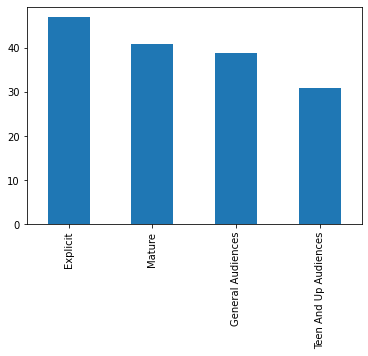

In [ ]:
#Distribution of classes
test['rating'].value_counts().plot(kind = 'bar')

In [ ]:
df2=pd.read_csv('/GD/My Drive/Colab Notebooks/Fanfiction/rating.csv')

In [ ]:
# \r and \n
df2['Body_Parsed_1'] = df2['body'].str.replace("\r", " ")
df2['Body_Parsed_1'] = df2['Body_Parsed_1'].str.replace("\n", " ")
df2['Body_Parsed_1'] = df2['Body_Parsed_1'].str.replace("    ", " ")
df2['Body_Parsed_1'] = df2['Body_Parsed_1'].str.replace("\t", " ")

In [ ]:
train = df2

In [ ]:

# test = df3 I'll make a test set later

In [ ]:
#Training set sample
train.head(5)

,work_id,title,author,rating,category,fandom,relationship,character,additional tags,language,...,words,chapters,comments,kudos,bookmarks,hits,all_kudos,all_bookmarks,body,Body_Parsed_1
0,36043723,Let's Talk About Dinosaurs,['hihellotya'],Mature,M/M,aekhephuue`nkhrabephuue`n | Bad Buddy: the Ser...,Ohm Pawat Chittsawangdee/Nanon Korapat Kirdpan...,"Ohm Pawat Chittsawangdee, Nanon Korapat Kirdpa...","doctor and archaeologists, Romance, I'm Bad At...",English,...,22412,10/?,25.0,74.0,7.0,1931,"['Purple_passiflora', 'tazparrow', 'coffeecup7...",[],Notes:\n\n \n\nNyasasaurus Pirringtoni is beli...,Notes: Nyasasaurus Pirringtoni is believed to...
1,37775314,Resurrected,['BlueClanMarkings'],Explicit,F/M,Mass Effect Trilogy,Female Shepard/Garrus Vakarian,"Garrus Vakarian, Tali'Zorah nar Rayya, Miranda...","Infiltrator (Mass Effect), Normandy-SR2, Mass ...",English,...,127885,15/?,19.0,42.0,4.0,951,"['Consumeroffanfics', 'lgiu', 'marantonia', 'D...",[],I opened my eyes and stared at a white ceiling...,I opened my eyes and stared at a white ceiling...
2,35885656,Silent Night ~ Christmas Eve with Severus Snap...,['Prince_Sev'],Mature,F/M,Harry Potter - J. K. Rowling,"Severus Snape/Reader, Severus Snape/You, Sever...",Severus Snape,"Christmas, Christmas Fluff, Holidays, One Shot...",English,...,13306,8/?,32.0,58.0,10.0,1031,"['sunsilverstar18', 'melyllvlol', 'Loyallonewo...",[],\n\n\nChristmas. Your favourite time of year....,Christmas. Your favourite time of year. The s...
3,38222218,Flower Day,['ceeloveswriting'],General Audiences,F/M,"Zhou Shu Hui Zhan | Jujutsu Kaisen (Manga), Z...","Fushiguro Megumi/Original Female Character(s),...",Fushiguro Megumi,"Alternate Universe, Reincarnation, Soulmates, ...",English,...,1231,1/1,NaN,NaN,NaN,0,[],[],It comes in a split second where their eyes me...,It comes in a split second where their eyes me...
4,38222215,Proximity,['Pire'],General Audiences,F/M,Pu nohiroakademia | Boku no Hero Academia | My...,"Amajiki Tamaki/Hadou Nejire, Amajiki Tamaki & ...","Hadou Nejire, Amajiki Tamaki","Tamajire, Tamaneji, Nejitama - Freeform, Slow ...",English,...,1125,1/1,NaN,NaN,NaN,0,[],[],He stopped suddenly as he passed the living ro...,He stopped suddenly as he passed the living ro...


I need to clean this up a little before I start doing stuff...

In [ ]:
##lets drop also the ... not rated

In [ ]:
rating_codes = {
    'General Audiences': 0,
    'Teen And Up Audiences': 1,
    'Mature': 2,
    'Explicit': 3,
}

In [ ]:
list_columns = ["title", "rating", "fandom", "character", "additional tags", "body", "Body_Parsed_1"]
df2_clean1 = df2[list_columns]

In [ ]:
# Category mapping
df2_clean1['Rating_Code'] = df2_clean1['rating']
df2_clean1 = df2_clean1.replace({'Rating_Code':rating_codes})
df2_clean1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,title,rating,fandom,character,additional tags,body,Body_Parsed_1,Rating_Code
0,Let's Talk About Dinosaurs,Mature,aekhephuue`nkhrabephuue`n | Bad Buddy: the Ser...,"Ohm Pawat Chittsawangdee, Nanon Korapat Kirdpa...","doctor and archaeologists, Romance, I'm Bad At...",Notes:\n\n \n\nNyasasaurus Pirringtoni is beli...,Notes: Nyasasaurus Pirringtoni is believed to...,2
1,Resurrected,Explicit,Mass Effect Trilogy,"Garrus Vakarian, Tali'Zorah nar Rayya, Miranda...","Infiltrator (Mass Effect), Normandy-SR2, Mass ...",I opened my eyes and stared at a white ceiling...,I opened my eyes and stared at a white ceiling...,3
2,Silent Night ~ Christmas Eve with Severus Snap...,Mature,Harry Potter - J. K. Rowling,Severus Snape,"Christmas, Christmas Fluff, Holidays, One Shot...",\n\n\nChristmas. Your favourite time of year....,Christmas. Your favourite time of year. The s...,2
3,Flower Day,General Audiences,"Zhou Shu Hui Zhan | Jujutsu Kaisen (Manga), Z...",Fushiguro Megumi,"Alternate Universe, Reincarnation, Soulmates, ...",It comes in a split second where their eyes me...,It comes in a split second where their eyes me...,0
4,Proximity,General Audiences,Pu nohiroakademia | Boku no Hero Academia | My...,"Hadou Nejire, Amajiki Tamaki","Tamajire, Tamaneji, Nejitama - Freeform, Slow ...",He stopped suddenly as he passed the living ro...,He stopped suddenly as he passed the living ro...,0
...,...,...,...,...,...,...,...,...
500,Days in Violet,Mature,"Hawkeye (TV 2021), Marvel Cinematic Universe, ...","Yelena Belova, Kate Bishop, Eleanor Bishop (Ma...","victorian au, Lesbian Yelena Belova, Kate is f...",\n (See the end of the chapter for n...,(See the end of the chapter for notes.) ...,2
501,I can treat you better,Teen And Up Audiences,"Sonic the Hedgehog - All Media Types, Sonic th...","Scourge the Hedgehog, Zonic the Zone Cop","Tooth-Rotting Fluff, Romantic Fluff, Hurt/Comf...",Zonic walked down the hallway of one of the pr...,Zonic walked down the hallway of one of the pr...,1
502,"From Today On, I Start Anew",Explicit,Kyou Kara Maou!,"Shibuya Yuuri, Wolfram von Bielefeld, Murata K...","Alternate Universe - Time Travel, Alternate Ca...",Tragedy strikes\n\n\nI wake up to the sound of...,Tragedy strikes I wake up to the sound of th...,3
503,Melodies at Midnight,Explicit,"Final Fantasy VII Remake (Video Game 2020), Fi...","Tifa Lockhart, Cloud Strife, Denzel (Compilati...","Angst, Heavy Angst, Past Zerith, canon complia...",Hello!\n\nThanks for stopping by to read this!...,Hello! Thanks for stopping by to read this! ...,3


In [ ]:
train = df2_clean1
train

,title,rating,fandom,character,additional tags,body,Body_Parsed_1,Rating_Code
0,Let's Talk About Dinosaurs,Mature,aekhephuue`nkhrabephuue`n | Bad Buddy: the Ser...,"Ohm Pawat Chittsawangdee, Nanon Korapat Kirdpa...","doctor and archaeologists, Romance, I'm Bad At...",Notes:\n\n \n\nNyasasaurus Pirringtoni is beli...,Notes: Nyasasaurus Pirringtoni is believed to...,2
1,Resurrected,Explicit,Mass Effect Trilogy,"Garrus Vakarian, Tali'Zorah nar Rayya, Miranda...","Infiltrator (Mass Effect), Normandy-SR2, Mass ...",I opened my eyes and stared at a white ceiling...,I opened my eyes and stared at a white ceiling...,3
2,Silent Night ~ Christmas Eve with Severus Snap...,Mature,Harry Potter - J. K. Rowling,Severus Snape,"Christmas, Christmas Fluff, Holidays, One Shot...",\n\n\nChristmas. Your favourite time of year....,Christmas. Your favourite time of year. The s...,2
3,Flower Day,General Audiences,"Zhou Shu Hui Zhan | Jujutsu Kaisen (Manga), Z...",Fushiguro Megumi,"Alternate Universe, Reincarnation, Soulmates, ...",It comes in a split second where their eyes me...,It comes in a split second where their eyes me...,0
4,Proximity,General Audiences,Pu nohiroakademia | Boku no Hero Academia | My...,"Hadou Nejire, Amajiki Tamaki","Tamajire, Tamaneji, Nejitama - Freeform, Slow ...",He stopped suddenly as he passed the living ro...,He stopped suddenly as he passed the living ro...,0
...,...,...,...,...,...,...,...,...
500,Days in Violet,Mature,"Hawkeye (TV 2021), Marvel Cinematic Universe, ...","Yelena Belova, Kate Bishop, Eleanor Bishop (Ma...","victorian au, Lesbian Yelena Belova, Kate is f...",\n (See the end of the chapter for n...,(See the end of the chapter for notes.) ...,2
501,I can treat you better,Teen And Up Audiences,"Sonic the Hedgehog - All Media Types, Sonic th...","Scourge the Hedgehog, Zonic the Zone Cop","Tooth-Rotting Fluff, Romantic Fluff, Hurt/Comf...",Zonic walked down the hallway of one of the pr...,Zonic walked down the hallway of one of the pr...,1
502,"From Today On, I Start Anew",Explicit,Kyou Kara Maou!,"Shibuya Yuuri, Wolfram von Bielefeld, Murata K...","Alternate Universe - Time Travel, Alternate Ca...",Tragedy strikes\n\n\nI wake up to the sound of...,Tragedy strikes I wake up to the sound of th...,3
503,Melodies at Midnight,Explicit,"Final Fantasy VII Remake (Video Game 2020), Fi...","Tifa Lockhart, Cloud Strife, Denzel (Compilati...","Angst, Heavy Angst, Past Zerith, canon complia...",Hello!\n\nThanks for stopping by to read this!...,Hello! Thanks for stopping by to read this! ...,3


In [ ]:
#unique classes
train['Rating_Code'].unique()

array([2, 3, 0, 1])

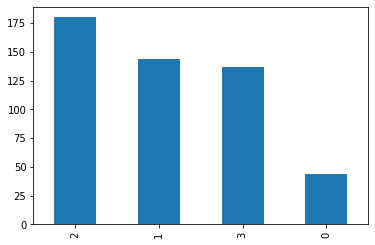

In [ ]:
#Distribution of classes
train['Rating_Code'].value_counts().plot(kind = 'bar')
#M T E G

In [ ]:
DATA_COLUMN = 'Body_Parsed_1'
LABEL_COLUMN = 'Rating_Code'
# The list containing all the classes (train['SECTION'].unique())
label_list = [0, 1, 2, 3]

In [ ]:
from sklearn.model_selection import train_test_split

train, val =  train_test_split(train, test_size = 0.2, random_state = 100)

In [ ]:
print("Training Set Shape :", train.shape)
print("Validation Set Shape :", val.shape)
print("Test Set Shape :", test.shape)

Training Set Shape : (404, 8)
Validation Set Shape : (101, 8)
Test Set Shape : (158, 23)


In [ ]:
#Features in the dataset
train.columns

Index(['title', 'rating', 'fandom', 'character', 'additional tags', 'body',
       'Body_Parsed_1', 'Rating_Code'],
      dtype='object')

Data Preprocessing BERT model accept only a specific type of input and the datasets are usually structured to have have the following four features:

guid : A unique id that represents an observation. text_a : The text we need to classify into given categories text_b: It is used when we're training a model to understand the relationship between sentences and it does not apply for classification problems. label: It consists of the labels or classes or categories that a given text belongs to. In our dataset we have text_a and label. The following code block will create objects for each of the above mentioned features for all the records in our dataset using the InputExample class provided in the BERT library.

In [ ]:
train_InputExamples = train.apply(lambda x: bert.run_classifier.InputExample(guid=None,
                                                                   text_a = x[DATA_COLUMN], 
                                                                   text_b = None, 
                                                                   label = x[LABEL_COLUMN]), axis = 1)

val_InputExamples = val.apply(lambda x: bert.run_classifier.InputExample(guid=None, 
                                                                   text_a = x[DATA_COLUMN], 
                                                                   text_b = None, 
                                                                   label = x[LABEL_COLUMN]), axis = 1)

In [ ]:
print("Row 0 - guid of training set : ", train_InputExamples.iloc[0].guid)
print("\n__________\nRow 0 - text_a of training set : ", train_InputExamples.iloc[0].text_a)
print("\n__________\nRow 0 - text_b of training set : ", train_InputExamples.iloc[0].text_b)
print("\n__________\nRow 0 - label of training set : ", train_InputExamples.iloc[0].label)

Row 0 - guid of training set :  None

__________
Row 0 - text_a of training set :  It wasn't supposed to be like this.   When asked why she wanted to fight for Skyrim, it made sense at the time to pick up a blade in the name of her Nordic ancestors. Born of prophecy, and with her mother's Nordic blood pounding in her veins, both sides expected her to choose one in hopes of ending the war sooner.   So she did. She pledged her life and soul to the cause. Because that was the way it had to be.   Because she was naive.  Nothing could have prepared her for the wicked imaginations of blood-thirsty men. All of the books in all the libraries of Nirn couldn't bestow enough knowledge to give her a clue as to what awaited her in the darkest parts of a man's mind.   Because the truth was, Irina had become arrogant. It was inevitable after a year of questing, fighting, and bleeding for the land in a successful endeavor to stop the dragon which threatened to devour the realm.   Her power flourished 

We will now get down to business with the pretrained BERT. In this example we will use the bert_uncased_L-12_H-768_A-12/1 model. To check all available versions click here.

We will be using the vocab.txt file in the model to map the words in the dataset to indexes. Also the loaded BERT model is trained on uncased/lowercase data and hence the data we feed to train the model should also be of lowercase.

In [ ]:
# This is a path to an uncased (all lowercase) version of BERT
BERT_MODEL_HUB = "https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1"

def create_tokenizer_from_hub_module():
  """Get the vocab file and casing info from the Hub module."""
  with tf.Graph().as_default():
    bert_module = hub.Module(BERT_MODEL_HUB)
    tokenization_info = bert_module(signature="tokenization_info", as_dict=True)
    with tf.Session() as sess:
      vocab_file, do_lower_case = sess.run([tokenization_info["vocab_file"],
                                            tokenization_info["do_lower_case"]])
      
  return bert.tokenization.FullTokenizer(
      vocab_file=vocab_file, do_lower_case=do_lower_case)

tokenizer = create_tokenizer_from_hub_module()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [ ]:
#Here is what the tokenised sample of the first training set observation looks like
print(tokenizer.tokenize(train_InputExamples.iloc[0].text_a))

['it', 'wasn', "'", 't', 'supposed', 'to', 'be', 'like', 'this', '.', 'when', 'asked', 'why', 'she', 'wanted', 'to', 'fight', 'for', 'sky', '##rim', ',', 'it', 'made', 'sense', 'at', 'the', 'time', 'to', 'pick', 'up', 'a', 'blade', 'in', 'the', 'name', 'of', 'her', 'nordic', 'ancestors', '.', 'born', 'of', 'prophecy', ',', 'and', 'with', 'her', 'mother', "'", 's', 'nordic', 'blood', 'pounding', 'in', 'her', 'veins', ',', 'both', 'sides', 'expected', 'her', 'to', 'choose', 'one', 'in', 'hopes', 'of', 'ending', 'the', 'war', 'sooner', '.', 'so', 'she', 'did', '.', 'she', 'pledged', 'her', 'life', 'and', 'soul', 'to', 'the', 'cause', '.', 'because', 'that', 'was', 'the', 'way', 'it', 'had', 'to', 'be', '.', 'because', 'she', 'was', 'naive', '.', 'nothing', 'could', 'have', 'prepared', 'her', 'for', 'the', 'wicked', 'imagination', '##s', 'of', 'blood', '-', 'thirsty', 'men', '.', 'all', 'of', 'the', 'books', 'in', 'all', 'the', 'libraries', 'of', 'ni', '##rn', 'couldn', "'", 't', 'best', '

We will now format out text in to input features which the BERT model expects. We will also set a sequence length which will be the length of the input features.

Okay so this is where you set the length

In [ ]:
MAX_SEQ_LENGTH = 125
#Convert our train and validation features to InputFeatures that BERT understands.
train_features = bert.run_classifier.convert_examples_to_features(train_InputExamples, label_list, MAX_SEQ_LENGTH, tokenizer)
  
val_features = bert.run_classifier.convert_examples_to_features(val_InputExamples, label_list, MAX_SEQ_LENGTH, tokenizer)

INFO:tensorflow:Writing example 0 of 404


INFO:tensorflow:Writing example 0 of 404


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] it wasn ' t supposed to be like this . when asked why she wanted to fight for sky ##rim , it made sense at the time to pick up a blade in the name of her nordic ancestors . born of prophecy , and with her mother ' s nordic blood pounding in her veins , both sides expected her to choose one in hopes of ending the war sooner . so she did . she pledged her life and soul to the cause . because that was the way it had to be . because she was naive . nothing could have prepared her for the wicked imagination ##s of blood - thirsty men . all of the books in all [SEP]


INFO:tensorflow:tokens: [CLS] it wasn ' t supposed to be like this . when asked why she wanted to fight for sky ##rim , it made sense at the time to pick up a blade in the name of her nordic ancestors . born of prophecy , and with her mother ' s nordic blood pounding in her veins , both sides expected her to choose one in hopes of ending the war sooner . so she did . she pledged her life and soul to the cause . because that was the way it had to be . because she was naive . nothing could have prepared her for the wicked imagination ##s of blood - thirsty men . all of the books in all [SEP]


INFO:tensorflow:input_ids: 101 2009 2347 1005 1056 4011 2000 2022 2066 2023 1012 2043 2356 2339 2016 2359 2000 2954 2005 3712 20026 1010 2009 2081 3168 2012 1996 2051 2000 4060 2039 1037 6085 1999 1996 2171 1997 2014 13649 10748 1012 2141 1997 14951 1010 1998 2007 2014 2388 1005 1055 13649 2668 9836 1999 2014 9607 1010 2119 3903 3517 2014 2000 5454 2028 1999 8069 1997 4566 1996 2162 10076 1012 2061 2016 2106 1012 2016 16970 2014 2166 1998 3969 2000 1996 3426 1012 2138 2008 2001 1996 2126 2009 2018 2000 2022 1012 2138 2016 2001 15743 1012 2498 2071 2031 4810 2014 2005 1996 10433 9647 2015 1997 2668 1011 24907 2273 1012 2035 1997 1996 2808 1999 2035 102


INFO:tensorflow:input_ids: 101 2009 2347 1005 1056 4011 2000 2022 2066 2023 1012 2043 2356 2339 2016 2359 2000 2954 2005 3712 20026 1010 2009 2081 3168 2012 1996 2051 2000 4060 2039 1037 6085 1999 1996 2171 1997 2014 13649 10748 1012 2141 1997 14951 1010 1998 2007 2014 2388 1005 1055 13649 2668 9836 1999 2014 9607 1010 2119 3903 3517 2014 2000 5454 2028 1999 8069 1997 4566 1996 2162 10076 1012 2061 2016 2106 1012 2016 16970 2014 2166 1998 3969 2000 1996 3426 1012 2138 2008 2001 1996 2126 2009 2018 2000 2022 1012 2138 2016 2001 15743 1012 2498 2071 2031 4810 2014 2005 1996 10433 9647 2015 1997 2668 1011 24907 2273 1012 2035 1997 1996 2808 1999 2035 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 3 (id = 3)


INFO:tensorflow:label: 3 (id = 3)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] in the olympic peninsula of northwest washington state , there existed my hometown of forks , where it was constantly over ##cast and raining . here especially more than anywhere else in the united states . however , my father , charlie swan , the chief of police of our home , and i were driving away from forks in his cruiser . i had brought my copy of the hero and the crown by robin mckinley with me to keep me occupied while charlie tapped his thumbs along to my newest cd . i had been surprised when he also enjoyed listening to fall out boy , as he didn ' t really enjoy listening to green day or the gorilla ##z [SEP]


INFO:tensorflow:tokens: [CLS] in the olympic peninsula of northwest washington state , there existed my hometown of forks , where it was constantly over ##cast and raining . here especially more than anywhere else in the united states . however , my father , charlie swan , the chief of police of our home , and i were driving away from forks in his cruiser . i had brought my copy of the hero and the crown by robin mckinley with me to keep me occupied while charlie tapped his thumbs along to my newest cd . i had been surprised when he also enjoyed listening to fall out boy , as he didn ' t really enjoy listening to green day or the gorilla ##z [SEP]


INFO:tensorflow:input_ids: 101 1999 1996 4386 6000 1997 4514 2899 2110 1010 2045 5839 2026 9627 1997 19896 1010 2073 2009 2001 7887 2058 10526 1998 24057 1012 2182 2926 2062 2084 5973 2842 1999 1996 2142 2163 1012 2174 1010 2026 2269 1010 4918 10677 1010 1996 2708 1997 2610 1997 2256 2188 1010 1998 1045 2020 4439 2185 2013 19896 1999 2010 10844 1012 1045 2018 2716 2026 6100 1997 1996 5394 1998 1996 4410 2011 5863 22121 2007 2033 2000 2562 2033 4548 2096 4918 10410 2010 16784 2247 2000 2026 14751 3729 1012 1045 2018 2042 4527 2043 2002 2036 5632 5962 2000 2991 2041 2879 1010 2004 2002 2134 1005 1056 2428 5959 5962 2000 2665 2154 2030 1996 23526 2480 102


INFO:tensorflow:input_ids: 101 1999 1996 4386 6000 1997 4514 2899 2110 1010 2045 5839 2026 9627 1997 19896 1010 2073 2009 2001 7887 2058 10526 1998 24057 1012 2182 2926 2062 2084 5973 2842 1999 1996 2142 2163 1012 2174 1010 2026 2269 1010 4918 10677 1010 1996 2708 1997 2610 1997 2256 2188 1010 1998 1045 2020 4439 2185 2013 19896 1999 2010 10844 1012 1045 2018 2716 2026 6100 1997 1996 5394 1998 1996 4410 2011 5863 22121 2007 2033 2000 2562 2033 4548 2096 4918 10410 2010 16784 2247 2000 2026 14751 3729 1012 1045 2018 2042 4527 2043 2002 2036 5632 5962 2000 2991 2041 2879 1010 2004 2002 2134 1005 1056 2428 5959 5962 2000 2665 2154 2030 1996 23526 2480 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 2 (id = 2)


INFO:tensorflow:label: 2 (id = 2)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] was this , as re ##mus would likely put it , something of a dick move ? well . logan had to admit that probably it was . but he was hoping it would be worth it . my flight was canceled , he texted virgil . they ' re saying they ' ll get me one tomorrow evening instead . virgil began typing at once . he spent perhaps two and a half minutes , the little dots disappearing and re ##app ##earing on logan ' s screen , before sending only : oh ok logan already regretted this , the two tiny words of resignation lan ##cing directly through his heart , made worse by the knowledge that he was the [SEP]


INFO:tensorflow:tokens: [CLS] was this , as re ##mus would likely put it , something of a dick move ? well . logan had to admit that probably it was . but he was hoping it would be worth it . my flight was canceled , he texted virgil . they ' re saying they ' ll get me one tomorrow evening instead . virgil began typing at once . he spent perhaps two and a half minutes , the little dots disappearing and re ##app ##earing on logan ' s screen , before sending only : oh ok logan already regretted this , the two tiny words of resignation lan ##cing directly through his heart , made worse by the knowledge that he was the [SEP]


INFO:tensorflow:input_ids: 101 2001 2023 1010 2004 2128 7606 2052 3497 2404 2009 1010 2242 1997 1037 5980 2693 1029 2092 1012 6307 2018 2000 6449 2008 2763 2009 2001 1012 2021 2002 2001 5327 2009 2052 2022 4276 2009 1012 2026 3462 2001 13261 1010 2002 24637 17270 1012 2027 1005 2128 3038 2027 1005 2222 2131 2033 2028 4826 3944 2612 1012 17270 2211 22868 2012 2320 1012 2002 2985 3383 2048 1998 1037 2431 2781 1010 1996 2210 14981 14489 1998 2128 29098 27242 2006 6307 1005 1055 3898 1010 2077 6016 2069 1024 2821 7929 6307 2525 18991 2023 1010 1996 2048 4714 2616 1997 8172 17595 6129 3495 2083 2010 2540 1010 2081 4788 2011 1996 3716 2008 2002 2001 1996 102


INFO:tensorflow:input_ids: 101 2001 2023 1010 2004 2128 7606 2052 3497 2404 2009 1010 2242 1997 1037 5980 2693 1029 2092 1012 6307 2018 2000 6449 2008 2763 2009 2001 1012 2021 2002 2001 5327 2009 2052 2022 4276 2009 1012 2026 3462 2001 13261 1010 2002 24637 17270 1012 2027 1005 2128 3038 2027 1005 2222 2131 2033 2028 4826 3944 2612 1012 17270 2211 22868 2012 2320 1012 2002 2985 3383 2048 1998 1037 2431 2781 1010 1996 2210 14981 14489 1998 2128 29098 27242 2006 6307 1005 1055 3898 1010 2077 6016 2069 1024 2821 7929 6307 2525 18991 2023 1010 1996 2048 4714 2616 1997 8172 17595 6129 3495 2083 2010 2540 1010 2081 4788 2011 1996 3716 2008 2002 2001 1996 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] a / n : set immediately after code of honour . thanks for reading . despite code of honour being one of the most cr ##inge ##worthy episodes of tn ##g , there were some brilliant data / tasha moments in that episode . yes , i will go down defending this ship . this story explores those moments and some missing scenes . this is a fan - made work of imagination . this is a re ##tell ##ing of tn ##g series one . my attempt is to weave in missing scenes and a few original adventures to expand on the first season . it ' s a little au and a bit of a roller ##co ##aster with flu ##ff [SEP]


INFO:tensorflow:tokens: [CLS] a / n : set immediately after code of honour . thanks for reading . despite code of honour being one of the most cr ##inge ##worthy episodes of tn ##g , there were some brilliant data / tasha moments in that episode . yes , i will go down defending this ship . this story explores those moments and some missing scenes . this is a fan - made work of imagination . this is a re ##tell ##ing of tn ##g series one . my attempt is to weave in missing scenes and a few original adventures to expand on the first season . it ' s a little au and a bit of a roller ##co ##aster with flu ##ff [SEP]


INFO:tensorflow:input_ids: 101 1037 1013 1050 1024 2275 3202 2044 3642 1997 6225 1012 4283 2005 3752 1012 2750 3642 1997 6225 2108 2028 1997 1996 2087 13675 23496 13966 4178 1997 28286 2290 1010 2045 2020 2070 8235 2951 1013 25448 5312 1999 2008 2792 1012 2748 1010 1045 2097 2175 2091 6984 2023 2911 1012 2023 2466 15102 2216 5312 1998 2070 4394 5019 1012 2023 2003 1037 5470 1011 2081 2147 1997 9647 1012 2023 2003 1037 2128 23567 2075 1997 28286 2290 2186 2028 1012 2026 3535 2003 2000 25308 1999 4394 5019 1998 1037 2261 2434 7357 2000 7818 2006 1996 2034 2161 1012 2009 1005 1055 1037 2210 8740 1998 1037 2978 1997 1037 11220 3597 24268 2007 19857 4246 102


INFO:tensorflow:input_ids: 101 1037 1013 1050 1024 2275 3202 2044 3642 1997 6225 1012 4283 2005 3752 1012 2750 3642 1997 6225 2108 2028 1997 1996 2087 13675 23496 13966 4178 1997 28286 2290 1010 2045 2020 2070 8235 2951 1013 25448 5312 1999 2008 2792 1012 2748 1010 1045 2097 2175 2091 6984 2023 2911 1012 2023 2466 15102 2216 5312 1998 2070 4394 5019 1012 2023 2003 1037 5470 1011 2081 2147 1997 9647 1012 2023 2003 1037 2128 23567 2075 1997 28286 2290 2186 2028 1012 2026 3535 2003 2000 25308 1999 4394 5019 1998 1037 2261 2434 7357 2000 7818 2006 1996 2034 2161 1012 2009 1005 1055 1037 2210 8740 1998 1037 2978 1997 1037 11220 3597 24268 2007 19857 4246 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] they are far from home . the jedi pad ##awan torn from her war . the bio ##nic super ##sol ##dier trapped in a part of the galaxy he never knew existed before . two lives disrupted for the crude pleasure of a hunter ' s game . she saw him when they were dropped on the island . cages of people reduced to prey . the ship opened fire and every victim ran , but he , he raised his hands and an energy shield formed from them . so she followed him into the jungle . he ' s still waiting to wake up and find this nightmare has ended . he knows he should have been more cautious , and [SEP]


INFO:tensorflow:tokens: [CLS] they are far from home . the jedi pad ##awan torn from her war . the bio ##nic super ##sol ##dier trapped in a part of the galaxy he never knew existed before . two lives disrupted for the crude pleasure of a hunter ' s game . she saw him when they were dropped on the island . cages of people reduced to prey . the ship opened fire and every victim ran , but he , he raised his hands and an energy shield formed from them . so she followed him into the jungle . he ' s still waiting to wake up and find this nightmare has ended . he knows he should have been more cautious , and [SEP]


INFO:tensorflow:input_ids: 101 2027 2024 2521 2013 2188 1012 1996 27273 11687 25903 7950 2013 2014 2162 1012 1996 16012 8713 3565 19454 24612 7567 1999 1037 2112 1997 1996 9088 2002 2196 2354 5839 2077 1012 2048 3268 20275 2005 1996 13587 5165 1997 1037 4477 1005 1055 2208 1012 2016 2387 2032 2043 2027 2020 3333 2006 1996 2479 1012 27157 1997 2111 4359 2000 8336 1012 1996 2911 2441 2543 1998 2296 6778 2743 1010 2021 2002 1010 2002 2992 2010 2398 1998 2019 2943 6099 2719 2013 2068 1012 2061 2016 2628 2032 2046 1996 8894 1012 2002 1005 1055 2145 3403 2000 5256 2039 1998 2424 2023 10103 2038 3092 1012 2002 4282 2002 2323 2031 2042 2062 17145 1010 1998 102


INFO:tensorflow:input_ids: 101 2027 2024 2521 2013 2188 1012 1996 27273 11687 25903 7950 2013 2014 2162 1012 1996 16012 8713 3565 19454 24612 7567 1999 1037 2112 1997 1996 9088 2002 2196 2354 5839 2077 1012 2048 3268 20275 2005 1996 13587 5165 1997 1037 4477 1005 1055 2208 1012 2016 2387 2032 2043 2027 2020 3333 2006 1996 2479 1012 27157 1997 2111 4359 2000 8336 1012 1996 2911 2441 2543 1998 2296 6778 2743 1010 2021 2002 1010 2002 2992 2010 2398 1998 2019 2943 6099 2719 2013 2068 1012 2061 2016 2628 2032 2046 1996 8894 1012 2002 1005 1055 2145 3403 2000 5256 2039 1998 2424 2023 10103 2038 3092 1012 2002 4282 2002 2323 2031 2042 2062 17145 1010 1998 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:Writing example 0 of 101


INFO:tensorflow:Writing example 0 of 101


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] day 1 prompt : new characters : harry and james sirius pairing : none rating : g harry looked down at the tiny bundle he held in his arms . he could scarcely believe that not only was the baby here , but he was harry ' s . his son . the thought of it took his breath away . james blinked and opened his eyes , seemingly staring up at his father . harry knew james wasn ' t really seeing him of course , only hours old , but harry smiled just the same . " hey there , little man , " harry said quietly , so as not to wake gin ##ny . " i ' m your [SEP]


INFO:tensorflow:tokens: [CLS] day 1 prompt : new characters : harry and james sirius pairing : none rating : g harry looked down at the tiny bundle he held in his arms . he could scarcely believe that not only was the baby here , but he was harry ' s . his son . the thought of it took his breath away . james blinked and opened his eyes , seemingly staring up at his father . harry knew james wasn ' t really seeing him of course , only hours old , but harry smiled just the same . " hey there , little man , " harry said quietly , so as not to wake gin ##ny . " i ' m your [SEP]


INFO:tensorflow:input_ids: 101 2154 1015 25732 1024 2047 3494 1024 4302 1998 2508 23466 22778 1024 3904 5790 1024 1043 4302 2246 2091 2012 1996 4714 14012 2002 2218 1999 2010 2608 1012 2002 2071 20071 2903 2008 2025 2069 2001 1996 3336 2182 1010 2021 2002 2001 4302 1005 1055 1012 2010 2365 1012 1996 2245 1997 2009 2165 2010 3052 2185 1012 2508 7948 1998 2441 2010 2159 1010 9428 4582 2039 2012 2010 2269 1012 4302 2354 2508 2347 1005 1056 2428 3773 2032 1997 2607 1010 2069 2847 2214 1010 2021 4302 3281 2074 1996 2168 1012 1000 4931 2045 1010 2210 2158 1010 1000 4302 2056 5168 1010 2061 2004 2025 2000 5256 18353 4890 1012 1000 1045 1005 1049 2115 102


INFO:tensorflow:input_ids: 101 2154 1015 25732 1024 2047 3494 1024 4302 1998 2508 23466 22778 1024 3904 5790 1024 1043 4302 2246 2091 2012 1996 4714 14012 2002 2218 1999 2010 2608 1012 2002 2071 20071 2903 2008 2025 2069 2001 1996 3336 2182 1010 2021 2002 2001 4302 1005 1055 1012 2010 2365 1012 1996 2245 1997 2009 2165 2010 3052 2185 1012 2508 7948 1998 2441 2010 2159 1010 9428 4582 2039 2012 2010 2269 1012 4302 2354 2508 2347 1005 1056 2428 3773 2032 1997 2607 1010 2069 2847 2214 1010 2021 4302 3281 2074 1996 2168 1012 1000 4931 2045 1010 2210 2158 1010 1000 4302 2056 5168 1010 2061 2004 2025 2000 5256 18353 4890 1012 1000 1045 1005 1049 2115 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] in moments when i am perfectly still , i can feel it all . the warmth of my own blood soaking into my night ##go ##wn . the iv being pulled out of my hand . the soft snow ##fl ##akes hitting my face . at this moment as i step onto the streets of gotham and the cold salty air sting ##s my face i am sure that when i stand still i will feel this moment as well . the water starts to run cold as i wash out more test tubes . i hear dr . kirk lang ##strom and his wife fran ##cine laugh behind me as they talk about their next vacation plans . they are a really [SEP]


INFO:tensorflow:tokens: [CLS] in moments when i am perfectly still , i can feel it all . the warmth of my own blood soaking into my night ##go ##wn . the iv being pulled out of my hand . the soft snow ##fl ##akes hitting my face . at this moment as i step onto the streets of gotham and the cold salty air sting ##s my face i am sure that when i stand still i will feel this moment as well . the water starts to run cold as i wash out more test tubes . i hear dr . kirk lang ##strom and his wife fran ##cine laugh behind me as they talk about their next vacation plans . they are a really [SEP]


INFO:tensorflow:input_ids: 101 1999 5312 2043 1045 2572 6669 2145 1010 1045 2064 2514 2009 2035 1012 1996 8251 1997 2026 2219 2668 22721 2046 2026 2305 3995 7962 1012 1996 4921 2108 2766 2041 1997 2026 2192 1012 1996 3730 4586 10258 20060 7294 2026 2227 1012 2012 2023 2617 2004 1045 3357 3031 1996 4534 1997 22814 1998 1996 3147 23592 2250 12072 2015 2026 2227 1045 2572 2469 2008 2043 1045 3233 2145 1045 2097 2514 2023 2617 2004 2092 1012 1996 2300 4627 2000 2448 3147 2004 1045 9378 2041 2062 3231 10868 1012 1045 2963 2852 1012 11332 11374 15687 1998 2010 2564 23151 16567 4756 2369 2033 2004 2027 2831 2055 2037 2279 10885 3488 1012 2027 2024 1037 2428 102


INFO:tensorflow:input_ids: 101 1999 5312 2043 1045 2572 6669 2145 1010 1045 2064 2514 2009 2035 1012 1996 8251 1997 2026 2219 2668 22721 2046 2026 2305 3995 7962 1012 1996 4921 2108 2766 2041 1997 2026 2192 1012 1996 3730 4586 10258 20060 7294 2026 2227 1012 2012 2023 2617 2004 1045 3357 3031 1996 4534 1997 22814 1998 1996 3147 23592 2250 12072 2015 2026 2227 1045 2572 2469 2008 2043 1045 3233 2145 1045 2097 2514 2023 2617 2004 2092 1012 1996 2300 4627 2000 2448 3147 2004 1045 9378 2041 2062 3231 10868 1012 1045 2963 2852 1012 11332 11374 15687 1998 2010 2564 23151 16567 4756 2369 2033 2004 2027 2831 2055 2037 2279 10885 3488 1012 2027 2024 1037 2428 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 3 (id = 3)


INFO:tensorflow:label: 3 (id = 3)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] see end note for star wars gloss ##ary and the man ##do ' a dictionary . ( see the end of the chapter for more notes . ) it had been a good day , until the stroke . actually , considering all that stroke led to , perhaps it was still a good day . luckily , the battle of the day had been almost done . cody had just handed his general back his lights ##abe ##r again , dryly commenting that general ken ##ob ##i shouldn ' t lose his " life " so often , playing on what he often told general sky ##walker about his own lights ##abe ##r . ken ##ob ##i had laughed . " ah [SEP]


INFO:tensorflow:tokens: [CLS] see end note for star wars gloss ##ary and the man ##do ' a dictionary . ( see the end of the chapter for more notes . ) it had been a good day , until the stroke . actually , considering all that stroke led to , perhaps it was still a good day . luckily , the battle of the day had been almost done . cody had just handed his general back his lights ##abe ##r again , dryly commenting that general ken ##ob ##i shouldn ' t lose his " life " so often , playing on what he often told general sky ##walker about his own lights ##abe ##r . ken ##ob ##i had laughed . " ah [SEP]


INFO:tensorflow:input_ids: 101 2156 2203 3602 2005 2732 5233 27068 5649 1998 1996 2158 3527 1005 1037 9206 1012 1006 2156 1996 2203 1997 1996 3127 2005 2062 3964 1012 1007 2009 2018 2042 1037 2204 2154 1010 2127 1996 6909 1012 2941 1010 6195 2035 2008 6909 2419 2000 1010 3383 2009 2001 2145 1037 2204 2154 1012 15798 1010 1996 2645 1997 1996 2154 2018 2042 2471 2589 1012 13326 2018 2074 4375 2010 2236 2067 2010 4597 16336 2099 2153 1010 20825 15591 2008 2236 6358 16429 2072 5807 1005 1056 4558 2010 1000 2166 1000 2061 2411 1010 2652 2006 2054 2002 2411 2409 2236 3712 26965 2055 2010 2219 4597 16336 2099 1012 6358 16429 2072 2018 4191 1012 1000 6289 102


INFO:tensorflow:input_ids: 101 2156 2203 3602 2005 2732 5233 27068 5649 1998 1996 2158 3527 1005 1037 9206 1012 1006 2156 1996 2203 1997 1996 3127 2005 2062 3964 1012 1007 2009 2018 2042 1037 2204 2154 1010 2127 1996 6909 1012 2941 1010 6195 2035 2008 6909 2419 2000 1010 3383 2009 2001 2145 1037 2204 2154 1012 15798 1010 1996 2645 1997 1996 2154 2018 2042 2471 2589 1012 13326 2018 2074 4375 2010 2236 2067 2010 4597 16336 2099 2153 1010 20825 15591 2008 2236 6358 16429 2072 5807 1005 1056 4558 2010 1000 2166 1000 2061 2411 1010 2652 2006 2054 2002 2411 2409 2236 3712 26965 2055 2010 2219 4597 16336 2099 1012 6358 16429 2072 2018 4191 1012 1000 6289 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] ( see the end of the chapter for notes . ) she hated it . . . she hated everything her family stood for . . . it was only her tenth attempt at today ' s dance , another one of their intensive tutor ##ing sessions and yet she made an outburst . she only saw how her tutor looked at her with disdain , like she was worse than the foul ##est smelling trash in all of the land . she only felt her stomach drop , the pit forming in swirl ##s in her gut as she realized what she had done . the echoing silence rang in her ears as everyone in the ballroom looked at her not in [SEP]


INFO:tensorflow:tokens: [CLS] ( see the end of the chapter for notes . ) she hated it . . . she hated everything her family stood for . . . it was only her tenth attempt at today ' s dance , another one of their intensive tutor ##ing sessions and yet she made an outburst . she only saw how her tutor looked at her with disdain , like she was worse than the foul ##est smelling trash in all of the land . she only felt her stomach drop , the pit forming in swirl ##s in her gut as she realized what she had done . the echoing silence rang in her ears as everyone in the ballroom looked at her not in [SEP]


INFO:tensorflow:input_ids: 101 1006 2156 1996 2203 1997 1996 3127 2005 3964 1012 1007 2016 6283 2009 1012 1012 1012 2016 6283 2673 2014 2155 2768 2005 1012 1012 1012 2009 2001 2069 2014 7891 3535 2012 2651 1005 1055 3153 1010 2178 2028 1997 2037 11806 14924 2075 6521 1998 2664 2016 2081 2019 27719 1012 2016 2069 2387 2129 2014 14924 2246 2012 2014 2007 25134 1010 2066 2016 2001 4788 2084 1996 12487 4355 19773 11669 1999 2035 1997 1996 2455 1012 2016 2069 2371 2014 4308 4530 1010 1996 6770 5716 1999 28693 2015 1999 2014 9535 2004 2016 3651 2054 2016 2018 2589 1012 1996 17142 4223 8369 1999 2014 5551 2004 3071 1999 1996 14307 2246 2012 2014 2025 1999 102


INFO:tensorflow:input_ids: 101 1006 2156 1996 2203 1997 1996 3127 2005 3964 1012 1007 2016 6283 2009 1012 1012 1012 2016 6283 2673 2014 2155 2768 2005 1012 1012 1012 2009 2001 2069 2014 7891 3535 2012 2651 1005 1055 3153 1010 2178 2028 1997 2037 11806 14924 2075 6521 1998 2664 2016 2081 2019 27719 1012 2016 2069 2387 2129 2014 14924 2246 2012 2014 2007 25134 1010 2066 2016 2001 4788 2084 1996 12487 4355 19773 11669 1999 2035 1997 1996 2455 1012 2016 2069 2371 2014 4308 4530 1010 1996 6770 5716 1999 28693 2015 1999 2014 9535 2004 2016 3651 2054 2016 2018 2589 1012 1996 17142 4223 8369 1999 2014 5551 2004 3071 1999 1996 14307 2246 2012 2014 2025 1999 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] " so , amy , have you thought about gr ##ad school again ? " " i ' m still not really sure about it , " amy replied , sliding another drawer shut . " the longer you wait , the harder it will be to get back into it , " jane , amy ' s boss , said . it hadn ' t even been six months since amy graduated and she ' d heard that question more times than she can count . if she wanted to get anywhere in her field , she needed a graduate degree . she knew this for ages and no one let her forget it . " i ' m just worried that [SEP]


INFO:tensorflow:tokens: [CLS] " so , amy , have you thought about gr ##ad school again ? " " i ' m still not really sure about it , " amy replied , sliding another drawer shut . " the longer you wait , the harder it will be to get back into it , " jane , amy ' s boss , said . it hadn ' t even been six months since amy graduated and she ' d heard that question more times than she can count . if she wanted to get anywhere in her field , she needed a graduate degree . she knew this for ages and no one let her forget it . " i ' m just worried that [SEP]


INFO:tensorflow:input_ids: 101 1000 2061 1010 6864 1010 2031 2017 2245 2055 24665 4215 2082 2153 1029 1000 1000 1045 1005 1049 2145 2025 2428 2469 2055 2009 1010 1000 6864 3880 1010 8058 2178 13065 3844 1012 1000 1996 2936 2017 3524 1010 1996 6211 2009 2097 2022 2000 2131 2067 2046 2009 1010 1000 4869 1010 6864 1005 1055 5795 1010 2056 1012 2009 2910 1005 1056 2130 2042 2416 2706 2144 6864 3852 1998 2016 1005 1040 2657 2008 3160 2062 2335 2084 2016 2064 4175 1012 2065 2016 2359 2000 2131 5973 1999 2014 2492 1010 2016 2734 1037 4619 3014 1012 2016 2354 2023 2005 5535 1998 2053 2028 2292 2014 5293 2009 1012 1000 1045 1005 1049 2074 5191 2008 102


INFO:tensorflow:input_ids: 101 1000 2061 1010 6864 1010 2031 2017 2245 2055 24665 4215 2082 2153 1029 1000 1000 1045 1005 1049 2145 2025 2428 2469 2055 2009 1010 1000 6864 3880 1010 8058 2178 13065 3844 1012 1000 1996 2936 2017 3524 1010 1996 6211 2009 2097 2022 2000 2131 2067 2046 2009 1010 1000 4869 1010 6864 1005 1055 5795 1010 2056 1012 2009 2910 1005 1056 2130 2042 2416 2706 2144 6864 3852 1998 2016 1005 1040 2657 2008 3160 2062 2335 2084 2016 2064 4175 1012 2065 2016 2359 2000 2131 5973 1999 2014 2492 1010 2016 2734 1037 4619 3014 1012 2016 2354 2023 2005 5535 1998 2053 2028 2292 2014 5293 2009 1012 1000 1045 1005 1049 2074 5191 2008 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 2 (id = 2)


INFO:tensorflow:label: 2 (id = 2)


In [ ]:
#Example on first observation in the training set
print("Sentence : ", train_InputExamples.iloc[0].text_a)
print("-"*30)
print("Tokens : ", tokenizer.tokenize(train_InputExamples.iloc[0].text_a))
print("-"*30)
print("Input IDs : ", train_features[0].input_ids)
print("-"*30)
print("Input Masks : ", train_features[0].input_mask)
print("-"*30)
print("Segment IDs : ", train_features[0].segment_ids)

Sentence :  It wasn't supposed to be like this.   When asked why she wanted to fight for Skyrim, it made sense at the time to pick up a blade in the name of her Nordic ancestors. Born of prophecy, and with her mother's Nordic blood pounding in her veins, both sides expected her to choose one in hopes of ending the war sooner.   So she did. She pledged her life and soul to the cause. Because that was the way it had to be.   Because she was naive.  Nothing could have prepared her for the wicked imaginations of blood-thirsty men. All of the books in all the libraries of Nirn couldn't bestow enough knowledge to give her a clue as to what awaited her in the darkest parts of a man's mind.   Because the truth was, Irina had become arrogant. It was inevitable after a year of questing, fighting, and bleeding for the land in a successful endeavor to stop the dragon which threatened to devour the realm.   Her power flourished with every foe's defeat. Each dragon soul absorbed fed her pride, swell

Creating A Multi-Class Classifier Model

In [ ]:
def create_model(is_predicting, input_ids, input_mask, segment_ids, labels,
                 num_labels):
  
  bert_module = hub.Module(
      BERT_MODEL_HUB,
      trainable=True)
  bert_inputs = dict(
      input_ids=input_ids,
      input_mask=input_mask,
      segment_ids=segment_ids)
  bert_outputs = bert_module(
      inputs=bert_inputs,
      signature="tokens",
      as_dict=True)

  # Use "pooled_output" for classification tasks on an entire sentence.
  # Use "sequence_outputs" for token-level output.
  output_layer = bert_outputs["pooled_output"]

  hidden_size = output_layer.shape[-1].value

  # Create our own layer to tune for politeness data.
  output_weights = tf.get_variable(
      "output_weights", [num_labels, hidden_size],
      initializer=tf.truncated_normal_initializer(stddev=0.02))

  output_bias = tf.get_variable(
      "output_bias", [num_labels], initializer=tf.zeros_initializer())

  with tf.variable_scope("loss"):

    # Dropout helps prevent overfitting
    output_layer = tf.nn.dropout(output_layer, keep_prob=0.9)

    logits = tf.matmul(output_layer, output_weights, transpose_b=True)
    logits = tf.nn.bias_add(logits, output_bias)
    log_probs = tf.nn.log_softmax(logits, axis=-1)

    # Convert labels into one-hot encoding
    one_hot_labels = tf.one_hot(labels, depth=num_labels, dtype=tf.float32)

    predicted_labels = tf.squeeze(tf.argmax(log_probs, axis=-1, output_type=tf.int32))
    # If we're predicting, we want predicted labels and the probabiltiies.
    if is_predicting:
      return (predicted_labels, log_probs)

    # If we're train/eval, compute loss between predicted and actual label
    per_example_loss = -tf.reduce_sum(one_hot_labels * log_probs, axis=-1)
    loss = tf.reduce_mean(per_example_loss)
    return (loss, predicted_labels, log_probs)

In [ ]:
#A function that adapts our model to work for training, evaluation, and prediction.

# model_fn_builder actually creates our model function
# using the passed parameters for num_labels, learning_rate, etc.
def model_fn_builder(num_labels, learning_rate, num_train_steps,
                     num_warmup_steps):
  """Returns `model_fn` closure for TPUEstimator."""
  def model_fn(features, labels, mode, params):  # pylint: disable=unused-argument
    """The `model_fn` for TPUEstimator."""

    input_ids = features["input_ids"]
    input_mask = features["input_mask"]
    segment_ids = features["segment_ids"]
    label_ids = features["label_ids"]

    is_predicting = (mode == tf.estimator.ModeKeys.PREDICT)
    
    # TRAIN and EVAL
    if not is_predicting:

      (loss, predicted_labels, log_probs) = create_model(
        is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels)

      train_op = bert.optimization.create_optimizer(
          loss, learning_rate, num_train_steps, num_warmup_steps, use_tpu=False)

      # Calculate evaluation metrics. 
      def metric_fn(label_ids, predicted_labels):
        accuracy = tf.metrics.accuracy(label_ids, predicted_labels)
        true_pos = tf.metrics.true_positives(
            label_ids,
            predicted_labels)
        true_neg = tf.metrics.true_negatives(
            label_ids,
            predicted_labels)   
        false_pos = tf.metrics.false_positives(
            label_ids,
            predicted_labels)  
        false_neg = tf.metrics.false_negatives(
            label_ids,
            predicted_labels)
        
        return {
            "eval_accuracy": accuracy,
            "true_positives": true_pos,
            "true_negatives": true_neg,
            "false_positives": false_pos,
            "false_negatives": false_neg
            }

      eval_metrics = metric_fn(label_ids, predicted_labels)

      if mode == tf.estimator.ModeKeys.TRAIN:
        return tf.estimator.EstimatorSpec(mode=mode,
          loss=loss,
          train_op=train_op)
      else:
          return tf.estimator.EstimatorSpec(mode=mode,
            loss=loss,
            eval_metric_ops=eval_metrics)
    else:
      (predicted_labels, log_probs) = create_model(
        is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels)

      predictions = {
          'probabilities': log_probs,
          'labels': predicted_labels
      }
      return tf.estimator.EstimatorSpec(mode, predictions=predictions)

  # Return the actual model function in the closure
  return model_fn

In [ ]:
# Compute train and warmup steps from batch size
# These hyperparameters are copied from this colab notebook (https://colab.sandbox.google.com/github/tensorflow/tpu/blob/master/tools/colab/bert_finetuning_with_cloud_tpus.ipynb)
BATCH_SIZE = 32
LEARNING_RATE = 2e-5
# LEARNING_RATE = 1e-5
NUM_TRAIN_EPOCHS = 3.0
# Warmup is a period of time where the learning rate is small and gradually increases--usually helps training.
WARMUP_PROPORTION = 0.1
# Model configs
SAVE_CHECKPOINTS_STEPS = 300
SAVE_SUMMARY_STEPS = 100

# Compute train and warmup steps from batch size
num_train_steps = int(len(train_features) / BATCH_SIZE * NUM_TRAIN_EPOCHS)
num_warmup_steps = int(num_train_steps * WARMUP_PROPORTION)

# Specify output directory and number of checkpoint steps to save
run_config = tf.estimator.RunConfig(
    model_dir=OUTPUT_DIR,
    save_summary_steps=SAVE_SUMMARY_STEPS,
    save_checkpoints_steps=SAVE_CHECKPOINTS_STEPS)

# Specify output directory and number of checkpoint steps to save
run_config = tf.estimator.RunConfig(
    model_dir=OUTPUT_DIR,
    save_summary_steps=SAVE_SUMMARY_STEPS,
    save_checkpoints_steps=SAVE_CHECKPOINTS_STEPS)

In [ ]:
#Initializing the model and the estimator
model_fn = model_fn_builder(
  num_labels=len(label_list),
  learning_rate=LEARNING_RATE,
  num_train_steps=num_train_steps,
  num_warmup_steps=num_warmup_steps)

estimator = tf.estimator.Estimator(
  model_fn=model_fn,
  config=run_config,
  params={"batch_size": BATCH_SIZE})

INFO:tensorflow:Using config: {'_model_dir': '/GD/My Drive/Colab Notebooks/BERT/bert_rating_category', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 300, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fb3d01a35d0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/GD/My Drive/Colab Notebooks/BERT/bert_rating_category', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 300, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fb3d01a35d0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


we will now create an input builder function that takes our training feature set (train_features) and produces a generator. This is a pretty standard design pattern for working with Tensorflow Estimators.

In [ ]:
# Create an input function for training. drop_remainder = True for using TPUs.
train_input_fn = bert.run_classifier.input_fn_builder(
    features=train_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=True,
    drop_remainder=False)

# Create an input function for validating. drop_remainder = True for using TPUs.
val_input_fn = run_classifier.input_fn_builder(
    features=val_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=False,
    drop_remainder=False)

In [ ]:
#Training the model
print(f'Beginning Training!')
current_time = datetime.now()
estimator.train(input_fn=train_input_fn, max_steps=num_train_steps)
print("Training took time ", datetime.now() - current_time)

Beginning Training!
INFO:tensorflow:Skipping training since max_steps has already saved.


INFO:tensorflow:Skipping training since max_steps has already saved.


Training took time  0:00:02.916424


In [ ]:
#Evaluating the model with Validation set
estimator.evaluate(input_fn=val_input_fn, steps=None)

INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2022-04-19T18:03:18Z


INFO:tensorflow:Starting evaluation at 2022-04-19T18:03:18Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /GD/My Drive/Colab Notebooks/BERT/bert_rating_category/model.ckpt-37


INFO:tensorflow:Restoring parameters from /GD/My Drive/Colab Notebooks/BERT/bert_rating_category/model.ckpt-37


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2022-04-19-18:04:28


INFO:tensorflow:Finished evaluation at 2022-04-19-18:04:28


INFO:tensorflow:Saving dict for global step 37: eval_accuracy = 0.33663365, false_negatives = 0.0, false_positives = 8.0, global_step = 37, loss = 1.2482295, true_negatives = 0.0, true_positives = 93.0


INFO:tensorflow:Saving dict for global step 37: eval_accuracy = 0.33663365, false_negatives = 0.0, false_positives = 8.0, global_step = 37, loss = 1.2482295, true_negatives = 0.0, true_positives = 93.0


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 37: /GD/My Drive/Colab Notebooks/BERT/bert_rating_category/model.ckpt-37


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 37: /GD/My Drive/Colab Notebooks/BERT/bert_rating_category/model.ckpt-37


{'eval_accuracy': 0.33663365,
 'false_negatives': 0.0,
 'false_positives': 8.0,
 'global_step': 37,
 'loss': 1.2482295,
 'true_negatives': 0.0,
 'true_positives': 93.0}

Okay so it got to 37 % eval accuracy with 125 tokens  and 3 epochs

I want to try with 250 tokens and 3 epochs
It got 37% with 250 tokens... and 3 epochs

I want to try with 512 tokens and 3 epochs
It got 31% with 512 tokens... okay it did worse...

Now it 34% percent accuracy with loss of 1.24 with 125 tokens and 3 epochs. 

I wan tto try with 125 tokens and 10 epochs? It keeps crashing

We got 34% with 125 tokens and 3 epochs

I need to test with a test set but I don't have that. 

In [ ]:
test

,work_id,title,author,rating,category,fandom,relationship,character,additional tags,language,...,words,chapters,comments,kudos,bookmarks,hits,all_kudos,all_bookmarks,body,Body_Parsed_1
0,35867929,The Call of Fate,['EmpressOfTheFlame'],Explicit,"F/M, M/M, Multi",HELIOS Rising Heroes (Video Game),"Jay Kidman/Reader, Various/Reader, Dino Albani...","Reader, You, Jay Kidman, Dino Albani, Akira Ot...","First Time, Praise Kink, Smut, Romance, Reader...",English,...,10191,15/?,1.0,13.0,1.0,455,['APH_Wonderland'],[],It would be accurate to say that Jay had been ...,It would be accurate to say that Jay had been ...
1,34628254,Sacrifice,['Thewonderfulwiccan'],Explicit,Multi,"Young Justice (Cartoon), Young Justice - All M...",Dick Grayson/Wally West,"Dick Grayson, Wally West, Barbara Gordon, M'ga...","Heavy Angst, Human Trafficking, Emotional Hurt...",English,...,51697,17/?,39.0,208.0,42.0,5721,"['herbalwigeon', 'spekkoekenak', 'NightBek', '...",[],They'd scream. \n\nThey'd cry. \n\nBeg to go h...,They'd scream. They'd cry. Beg to go home ...
2,38261965,Sick Leave,['Hemaris_diffinis'],Teen And Up Audiences,Gen,The Owl House (Cartoon),Eda Clawthorne/Raine Whispers,"Raine Whispers, Terra Snapdragon, Eda Clawthorne",Amber Derwin and Kayta are mentioned but not p...,English,...,7439,5/?,10.0,56.0,4.0,678,"['goblingorg', 'Dantsem', 'sapphicsoup', 'imlo...",[],"Ok, ok, I need to calm down and make a plan, R...","Ok, ok, I need to calm down and make a plan, R..."
4,38125645,"absence, hearts",['Marmeladeskies'],Explicit,M/M,Formula 1 RPF,Lando Norris/Max Verstappen/Daniel Ricciardo/C...,"Lando Norris, Michael Italiano, Charles Lecler...","Alpha/Beta/Omega Dynamics, Omegaverse, Pack Dy...",English,...,37314,21/27,625.0,512.0,41.0,18354,"['nonotwithoutyou', 'OneAccount', 'loveisme', ...",[],\n (See the end of the chapter for n...,(See the end of the chapter for notes.) ...
7,36500893,"God of Mischief, Master of Death",['CrazyArtChic'],Teen And Up Audiences,Gen,"Harry Potter - J. K. Rowling, The Avengers (Ma...",NaN,"Female Harry Potter - Character, Hermione Gran...","Rule 63, Time Travel Fix-It, Master of Death H...",English,...,112327,34/?,1044.0,1722.0,602.0,51838,"['Babyb34r', 'FreedomFighterKris', 'Zerilla', ...",[],"Chapter 1\n\n \n\nThe trial was a farce, and t...","Chapter 1 The trial was a farce, and they all..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190,236,Five People John Sheppard Didn't Expect to Mis...,['Kass'],Mature,M/M,Stargate Atlantis,John Sheppard/Rodney McKay,"John Sheppard, Rodney McKay","Remix, remixredux08, 5 Things",English,...,1382,1/1,4.0,76.0,3.0,1260,"['greenfizzpops', 'Brightbear', 'gingerpolyglo...",[],\n1. The guy with the bass at Bagram\n\n\nAll ...,1. The guy with the bass at Bagram All of t...
191,237,More of the Stars and Sea (The Three Meals Remix),['Kass'],General Audiences,F/M,Stargate Atlantis,Radek/Teyla,"Radek Zelenka, Teyla Emmagan","Remix, remixredux08",English,...,2624,1/1,8.0,30.0,4.0,953,"['Outnumbered18', 'Rocketscientists', 'Ravenne...",[],Mysterious power readings always meant trouble...,Mysterious power readings always meant trouble...
192,238,A Slice of College,['Kass'],Mature,F/F,Daria - Fandom,Daria/Jane,"Daria Morgendorfer, Jane Lane",First Time,English,...,3683,1/1,19.0,401.0,49.0,5235,"['future1dustries', 'scrawnycalc', 'originalbl...",[],"The first time they went for pizza in Boston, ...","The first time they went for pizza in Boston, ..."
194,241,Runaways,['Mollyamory (Molly)'],Mature,M/M,NSYNC,Lance Bass/Chris Kirkpatrick,"Lance Bass, Chris Kirkpatrick",Popslash - Freeform,English,...,11489,1/1,NaN,14.0,2.0,412,"['verilix', 'FrkAemelin', 'mandralyne', 'Rubic...",[],"""Are you packed?""\n\n""No,"" Chris said, letting...","""Are you packed?"" ""No,"" Chris said, letting s..."


In [ ]:
# rating_codes = {
#     'General Audiences': 0,
#     'Teen And Up Audiences': 1,
#     'Mature': 2,
#     'Explicit': 3,
# }
# A method to get predictions
def getPrediction(in_sentences):
  #A list to map the actual labels to the predictions
  labels = ['General Audiences', 'Teen and Up Audiences','Mature','Explicit']

  #Transforming the test data into BERT accepted form
  input_examples = [run_classifier.InputExample(guid="", text_a = x, text_b = None, label = 0) for x in in_sentences] 
  
  #Creating input features for Test data
  input_features = run_classifier.convert_examples_to_features(input_examples, label_list, MAX_SEQ_LENGTH, tokenizer)

  #Predicting the classes 
  predict_input_fn = run_classifier.input_fn_builder(features=input_features, seq_length=MAX_SEQ_LENGTH, is_training=False, drop_remainder=False)
  predictions = estimator.predict(predict_input_fn)
  return [(sentence, prediction['probabilities'],prediction['labels'], labels[prediction['labels']]) for sentence, prediction in zip(in_sentences, predictions)]

In [ ]:
pred_sentences = list(test['Body_Parsed_1'])

In [ ]:
predictions = getPrediction(pred_sentences)

INFO:tensorflow:Writing example 0 of 158


INFO:tensorflow:Writing example 0 of 158


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] it would be accurate to say that jay had been en ##amo ##red with you from the moment he saw you . after his divorce he had to admit to himself that having a love life might not be in the cards for him , he had loved and lost and he appreciated the experiences he had . his life had always involved his work and it wasn ' t so unusual that , if he were to ever meet another partner , they ' d be a hero just as busy as he was . he doesn ' t want to admit that the first thought he had when coming to terms with his crush on you was that it was ' [SEP]


INFO:tensorflow:tokens: [CLS] it would be accurate to say that jay had been en ##amo ##red with you from the moment he saw you . after his divorce he had to admit to himself that having a love life might not be in the cards for him , he had loved and lost and he appreciated the experiences he had . his life had always involved his work and it wasn ' t so unusual that , if he were to ever meet another partner , they ' d be a hero just as busy as he was . he doesn ' t want to admit that the first thought he had when coming to terms with his crush on you was that it was ' [SEP]


INFO:tensorflow:input_ids: 101 2009 2052 2022 8321 2000 2360 2008 6108 2018 2042 4372 22591 5596 2007 2017 2013 1996 2617 2002 2387 2017 1012 2044 2010 8179 2002 2018 2000 6449 2000 2370 2008 2383 1037 2293 2166 2453 2025 2022 1999 1996 5329 2005 2032 1010 2002 2018 3866 1998 2439 1998 2002 12315 1996 6322 2002 2018 1012 2010 2166 2018 2467 2920 2010 2147 1998 2009 2347 1005 1056 2061 5866 2008 1010 2065 2002 2020 2000 2412 3113 2178 4256 1010 2027 1005 1040 2022 1037 5394 2074 2004 5697 2004 2002 2001 1012 2002 2987 1005 1056 2215 2000 6449 2008 1996 2034 2245 2002 2018 2043 2746 2000 3408 2007 2010 10188 2006 2017 2001 2008 2009 2001 1005 102


INFO:tensorflow:input_ids: 101 2009 2052 2022 8321 2000 2360 2008 6108 2018 2042 4372 22591 5596 2007 2017 2013 1996 2617 2002 2387 2017 1012 2044 2010 8179 2002 2018 2000 6449 2000 2370 2008 2383 1037 2293 2166 2453 2025 2022 1999 1996 5329 2005 2032 1010 2002 2018 3866 1998 2439 1998 2002 12315 1996 6322 2002 2018 1012 2010 2166 2018 2467 2920 2010 2147 1998 2009 2347 1005 1056 2061 5866 2008 1010 2065 2002 2020 2000 2412 3113 2178 4256 1010 2027 1005 1040 2022 1037 5394 2074 2004 5697 2004 2002 2001 1012 2002 2987 1005 1056 2215 2000 6449 2008 1996 2034 2245 2002 2018 2043 2746 2000 3408 2007 2010 10188 2006 2017 2001 2008 2009 2001 1005 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] they ' d scream . they ' d cry . beg to go home to their parents , they ' d cl ##ing to his pan ##t legs , inc ##oh ##ere ##nt nonsense would come out of their tiny pathetic mouths . he wanted to tell them it was pointless , they were better off keeping quiet and taking what they gave them . but it was adorable , it really was . children . . . so precious . so innocent . so small . naive . he reached down and grabbed her chin and lifted her head and sighed , her blue eyes wide , tears running down her cheeks . " oh darling , " he co ##oed , [SEP]


INFO:tensorflow:tokens: [CLS] they ' d scream . they ' d cry . beg to go home to their parents , they ' d cl ##ing to his pan ##t legs , inc ##oh ##ere ##nt nonsense would come out of their tiny pathetic mouths . he wanted to tell them it was pointless , they were better off keeping quiet and taking what they gave them . but it was adorable , it really was . children . . . so precious . so innocent . so small . naive . he reached down and grabbed her chin and lifted her head and sighed , her blue eyes wide , tears running down her cheeks . " oh darling , " he co ##oed , [SEP]


INFO:tensorflow:input_ids: 101 2027 1005 1040 6978 1012 2027 1005 1040 5390 1012 11693 2000 2175 2188 2000 2037 3008 1010 2027 1005 1040 18856 2075 2000 2010 6090 2102 3456 1010 4297 11631 7869 3372 14652 2052 2272 2041 1997 2037 4714 17203 15076 1012 2002 2359 2000 2425 2068 2009 2001 23100 1010 2027 2020 2488 2125 4363 4251 1998 2635 2054 2027 2435 2068 1012 2021 2009 2001 23677 1010 2009 2428 2001 1012 2336 1012 1012 1012 2061 9062 1012 2061 7036 1012 2061 2235 1012 15743 1012 2002 2584 2091 1998 4046 2014 5413 1998 4196 2014 2132 1998 5489 1010 2014 2630 2159 2898 1010 4000 2770 2091 2014 6029 1012 1000 2821 9548 1010 1000 2002 2522 29099 1010 102


INFO:tensorflow:input_ids: 101 2027 1005 1040 6978 1012 2027 1005 1040 5390 1012 11693 2000 2175 2188 2000 2037 3008 1010 2027 1005 1040 18856 2075 2000 2010 6090 2102 3456 1010 4297 11631 7869 3372 14652 2052 2272 2041 1997 2037 4714 17203 15076 1012 2002 2359 2000 2425 2068 2009 2001 23100 1010 2027 2020 2488 2125 4363 4251 1998 2635 2054 2027 2435 2068 1012 2021 2009 2001 23677 1010 2009 2428 2001 1012 2336 1012 1012 1012 2061 9062 1012 2061 7036 1012 2061 2235 1012 15743 1012 2002 2584 2091 1998 4046 2014 5413 1998 4196 2014 2132 1998 5489 1010 2014 2630 2159 2898 1010 4000 2770 2091 2014 6029 1012 1000 2821 9548 1010 1000 2002 2522 29099 1010 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] ok , ok , i need to calm down and make a plan , rain ##e told them ##sel ##f . where am i ? what do i remember ? where seemed like the easier question to answer first . they were tied to chair in front of a small table . vines held them securely in place , all the way up to their shoulders and tight enough to make breathing uncomfortable . thorns threatened to cut them with every movement . they tried moving anyway . the vines were strong and had no give . they ' d definitely draw some blood . for now , that seemed to be a lost cause . the space around them was hard to [SEP]


INFO:tensorflow:tokens: [CLS] ok , ok , i need to calm down and make a plan , rain ##e told them ##sel ##f . where am i ? what do i remember ? where seemed like the easier question to answer first . they were tied to chair in front of a small table . vines held them securely in place , all the way up to their shoulders and tight enough to make breathing uncomfortable . thorns threatened to cut them with every movement . they tried moving anyway . the vines were strong and had no give . they ' d definitely draw some blood . for now , that seemed to be a lost cause . the space around them was hard to [SEP]


INFO:tensorflow:input_ids: 101 7929 1010 7929 1010 1045 2342 2000 5475 2091 1998 2191 1037 2933 1010 4542 2063 2409 2068 11246 2546 1012 2073 2572 1045 1029 2054 2079 1045 3342 1029 2073 2790 2066 1996 6082 3160 2000 3437 2034 1012 2027 2020 5079 2000 3242 1999 2392 1997 1037 2235 2795 1012 16702 2218 2068 28999 1999 2173 1010 2035 1996 2126 2039 2000 2037 4065 1998 4389 2438 2000 2191 5505 8796 1012 28408 5561 2000 3013 2068 2007 2296 2929 1012 2027 2699 3048 4312 1012 1996 16702 2020 2844 1998 2018 2053 2507 1012 2027 1005 1040 5791 4009 2070 2668 1012 2005 2085 1010 2008 2790 2000 2022 1037 2439 3426 1012 1996 2686 2105 2068 2001 2524 2000 102


INFO:tensorflow:input_ids: 101 7929 1010 7929 1010 1045 2342 2000 5475 2091 1998 2191 1037 2933 1010 4542 2063 2409 2068 11246 2546 1012 2073 2572 1045 1029 2054 2079 1045 3342 1029 2073 2790 2066 1996 6082 3160 2000 3437 2034 1012 2027 2020 5079 2000 3242 1999 2392 1997 1037 2235 2795 1012 16702 2218 2068 28999 1999 2173 1010 2035 1996 2126 2039 2000 2037 4065 1998 4389 2438 2000 2191 5505 8796 1012 28408 5561 2000 3013 2068 2007 2296 2929 1012 2027 2699 3048 4312 1012 1996 16702 2020 2844 1998 2018 2053 2507 1012 2027 1005 1040 5791 4009 2070 2668 1012 2005 2085 1010 2008 2790 2000 2022 1037 2439 3426 1012 1996 2686 2105 2068 2001 2524 2000 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] ( see the end of the chapter for notes . ) " harder - , " land ##o begged , " fuck , i want to come before my leg starts cr ##amp ##ing - " behind him , michael huffed out a breathless laugh , speeding up his thrusts . they were probably in the most uncomfortable position in the world right now , land ##o bent over , hands sprawled against the wall of the barn , bouncing up and down on michael under him , who was sat on an old fe ##rti ##lizer box to even out their height difference . the air was stuff ##y , it smelled like plant matter and animals and tractor fuel , and [SEP]


INFO:tensorflow:tokens: [CLS] ( see the end of the chapter for notes . ) " harder - , " land ##o begged , " fuck , i want to come before my leg starts cr ##amp ##ing - " behind him , michael huffed out a breathless laugh , speeding up his thrusts . they were probably in the most uncomfortable position in the world right now , land ##o bent over , hands sprawled against the wall of the barn , bouncing up and down on michael under him , who was sat on an old fe ##rti ##lizer box to even out their height difference . the air was stuff ##y , it smelled like plant matter and animals and tractor fuel , and [SEP]


INFO:tensorflow:input_ids: 101 1006 2156 1996 2203 1997 1996 3127 2005 3964 1012 1007 1000 6211 1011 1010 1000 2455 2080 12999 1010 1000 6616 1010 1045 2215 2000 2272 2077 2026 4190 4627 13675 16613 2075 1011 1000 2369 2032 1010 2745 25014 2041 1037 16701 4756 1010 21485 2039 2010 25842 1012 2027 2020 2763 1999 1996 2087 8796 2597 1999 1996 2088 2157 2085 1010 2455 2080 6260 2058 1010 2398 21212 2114 1996 2813 1997 1996 8659 1010 16361 2039 1998 2091 2006 2745 2104 2032 1010 2040 2001 2938 2006 2019 2214 10768 28228 28863 3482 2000 2130 2041 2037 4578 4489 1012 1996 2250 2001 4933 2100 1010 2009 9557 2066 3269 3043 1998 4176 1998 16358 4762 1010 1998 102


INFO:tensorflow:input_ids: 101 1006 2156 1996 2203 1997 1996 3127 2005 3964 1012 1007 1000 6211 1011 1010 1000 2455 2080 12999 1010 1000 6616 1010 1045 2215 2000 2272 2077 2026 4190 4627 13675 16613 2075 1011 1000 2369 2032 1010 2745 25014 2041 1037 16701 4756 1010 21485 2039 2010 25842 1012 2027 2020 2763 1999 1996 2087 8796 2597 1999 1996 2088 2157 2085 1010 2455 2080 6260 2058 1010 2398 21212 2114 1996 2813 1997 1996 8659 1010 16361 2039 1998 2091 2006 2745 2104 2032 1010 2040 2001 2938 2006 2019 2214 10768 28228 28863 3482 2000 2130 2041 2037 4578 4489 1012 1996 2250 2001 4933 2100 1010 2009 9557 2066 3269 3043 1998 4176 1998 16358 4762 1010 1998 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] chapter 1 the trial was a far ##ce , and they all knew it , yet odin insisted on carrying it out all the same . loki offered no resistance , resigned to his fate . no one defended him , and why would they ? they had never liked him , never accepted him as he was , and assumed him guilty in all things . ever since he had shown a pro ##cl ##ivity for magic over sword ##play , ever since they knew he could shift from male to female at will , he was assumed un ##trust ##worthy and freak ##ish . the lies ##mith . granted , he was at least partially guilty in the attempted take over [SEP]


INFO:tensorflow:tokens: [CLS] chapter 1 the trial was a far ##ce , and they all knew it , yet odin insisted on carrying it out all the same . loki offered no resistance , resigned to his fate . no one defended him , and why would they ? they had never liked him , never accepted him as he was , and assumed him guilty in all things . ever since he had shown a pro ##cl ##ivity for magic over sword ##play , ever since they knew he could shift from male to female at will , he was assumed un ##trust ##worthy and freak ##ish . the lies ##mith . granted , he was at least partially guilty in the attempted take over [SEP]


INFO:tensorflow:input_ids: 101 3127 1015 1996 3979 2001 1037 2521 3401 1010 1998 2027 2035 2354 2009 1010 2664 26195 7278 2006 4755 2009 2041 2035 1996 2168 1012 24143 3253 2053 5012 1010 5295 2000 2010 6580 1012 2053 2028 8047 2032 1010 1998 2339 2052 2027 1029 2027 2018 2196 4669 2032 1010 2196 3970 2032 2004 2002 2001 1010 1998 5071 2032 5905 1999 2035 2477 1012 2412 2144 2002 2018 3491 1037 4013 20464 7730 2005 3894 2058 4690 13068 1010 2412 2144 2027 2354 2002 2071 5670 2013 3287 2000 2931 2012 2097 1010 2002 2001 5071 4895 24669 13966 1998 11576 4509 1012 1996 3658 19864 1012 4379 1010 2002 2001 2012 2560 6822 5905 1999 1996 4692 2202 2058 102


INFO:tensorflow:input_ids: 101 3127 1015 1996 3979 2001 1037 2521 3401 1010 1998 2027 2035 2354 2009 1010 2664 26195 7278 2006 4755 2009 2041 2035 1996 2168 1012 24143 3253 2053 5012 1010 5295 2000 2010 6580 1012 2053 2028 8047 2032 1010 1998 2339 2052 2027 1029 2027 2018 2196 4669 2032 1010 2196 3970 2032 2004 2002 2001 1010 1998 5071 2032 5905 1999 2035 2477 1012 2412 2144 2002 2018 3491 1037 4013 20464 7730 2005 3894 2058 4690 13068 1010 2412 2144 2027 2354 2002 2071 5670 2013 3287 2000 2931 2012 2097 1010 2002 2001 5071 4895 24669 13966 1998 11576 4509 1012 1996 3658 19864 1012 4379 1010 2002 2001 2012 2560 6822 5905 1999 1996 4692 2202 2058 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /GD/My Drive/Colab Notebooks/BERT/bert_rating_category/model.ckpt-37


INFO:tensorflow:Restoring parameters from /GD/My Drive/Colab Notebooks/BERT/bert_rating_category/model.ckpt-37


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


In [ ]:
predictions[0]

('It would be accurate to say that Jay had been enamored with you from the moment he saw you.  After his divorce he had to admit to himself that having a love life might not be in the cards for him, he had loved and lost and he appreciated the experiences he had. His life had always involved his work and it wasn\'t so unusual that, if he were to ever meet another partner, they\'d be a hero just as busy as he was. He doesn\'t want to admit that the first thought he had when coming to terms with his crush on you was that it was \'convenient\' but you were so much more than that. A perfect match in many ways, a person who could challenge him to grow while also allowing him to take solace in them when needed.  He wasn\'t thinking at all about his destination when his patrol was over, not quite aimless but still surprised to see himself stopping in front of your room. Your relationship... He didn\'t know how to define it. Nothing explicitly romantic had happened yet he viewed you in a way t

In [ ]:
enc_labels = []
act_labels = []
for i in range(len(predictions)):
  enc_labels.append(predictions[i][2])
  act_labels.append(predictions[i][3])

In [ ]:
pd.DataFrame(enc_labels, columns = ['SECTION']).to_csv('/GD/My Drive/Colab Notebooks/Fanfiction/rating_test2.csv', index = False)

In [ ]:
test

,work_id,title,author,rating,category,fandom,relationship,character,additional tags,language,...,words,chapters,comments,kudos,bookmarks,hits,all_kudos,all_bookmarks,body,Body_Parsed_1
0,35867929,The Call of Fate,['EmpressOfTheFlame'],Explicit,"F/M, M/M, Multi",HELIOS Rising Heroes (Video Game),"Jay Kidman/Reader, Various/Reader, Dino Albani...","Reader, You, Jay Kidman, Dino Albani, Akira Ot...","First Time, Praise Kink, Smut, Romance, Reader...",English,...,10191,15/?,1.0,13.0,1.0,455,['APH_Wonderland'],[],It would be accurate to say that Jay had been ...,It would be accurate to say that Jay had been ...
1,34628254,Sacrifice,['Thewonderfulwiccan'],Explicit,Multi,"Young Justice (Cartoon), Young Justice - All M...",Dick Grayson/Wally West,"Dick Grayson, Wally West, Barbara Gordon, M'ga...","Heavy Angst, Human Trafficking, Emotional Hurt...",English,...,51697,17/?,39.0,208.0,42.0,5721,"['herbalwigeon', 'spekkoekenak', 'NightBek', '...",[],They'd scream. \n\nThey'd cry. \n\nBeg to go h...,They'd scream. They'd cry. Beg to go home ...
2,38261965,Sick Leave,['Hemaris_diffinis'],Teen And Up Audiences,Gen,The Owl House (Cartoon),Eda Clawthorne/Raine Whispers,"Raine Whispers, Terra Snapdragon, Eda Clawthorne",Amber Derwin and Kayta are mentioned but not p...,English,...,7439,5/?,10.0,56.0,4.0,678,"['goblingorg', 'Dantsem', 'sapphicsoup', 'imlo...",[],"Ok, ok, I need to calm down and make a plan, R...","Ok, ok, I need to calm down and make a plan, R..."
4,38125645,"absence, hearts",['Marmeladeskies'],Explicit,M/M,Formula 1 RPF,Lando Norris/Max Verstappen/Daniel Ricciardo/C...,"Lando Norris, Michael Italiano, Charles Lecler...","Alpha/Beta/Omega Dynamics, Omegaverse, Pack Dy...",English,...,37314,21/27,625.0,512.0,41.0,18354,"['nonotwithoutyou', 'OneAccount', 'loveisme', ...",[],\n (See the end of the chapter for n...,(See the end of the chapter for notes.) ...
7,36500893,"God of Mischief, Master of Death",['CrazyArtChic'],Teen And Up Audiences,Gen,"Harry Potter - J. K. Rowling, The Avengers (Ma...",NaN,"Female Harry Potter - Character, Hermione Gran...","Rule 63, Time Travel Fix-It, Master of Death H...",English,...,112327,34/?,1044.0,1722.0,602.0,51838,"['Babyb34r', 'FreedomFighterKris', 'Zerilla', ...",[],"Chapter 1\n\n \n\nThe trial was a farce, and t...","Chapter 1 The trial was a farce, and they all..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190,236,Five People John Sheppard Didn't Expect to Mis...,['Kass'],Mature,M/M,Stargate Atlantis,John Sheppard/Rodney McKay,"John Sheppard, Rodney McKay","Remix, remixredux08, 5 Things",English,...,1382,1/1,4.0,76.0,3.0,1260,"['greenfizzpops', 'Brightbear', 'gingerpolyglo...",[],\n1. The guy with the bass at Bagram\n\n\nAll ...,1. The guy with the bass at Bagram All of t...
191,237,More of the Stars and Sea (The Three Meals Remix),['Kass'],General Audiences,F/M,Stargate Atlantis,Radek/Teyla,"Radek Zelenka, Teyla Emmagan","Remix, remixredux08",English,...,2624,1/1,8.0,30.0,4.0,953,"['Outnumbered18', 'Rocketscientists', 'Ravenne...",[],Mysterious power readings always meant trouble...,Mysterious power readings always meant trouble...
192,238,A Slice of College,['Kass'],Mature,F/F,Daria - Fandom,Daria/Jane,"Daria Morgendorfer, Jane Lane",First Time,English,...,3683,1/1,19.0,401.0,49.0,5235,"['future1dustries', 'scrawnycalc', 'originalbl...",[],"The first time they went for pizza in Boston, ...","The first time they went for pizza in Boston, ..."
194,241,Runaways,['Mollyamory (Molly)'],Mature,M/M,NSYNC,Lance Bass/Chris Kirkpatrick,"Lance Bass, Chris Kirkpatrick",Popslash - Freeform,English,...,11489,1/1,NaN,14.0,2.0,412,"['verilix', 'FrkAemelin', 'mandralyne', 'Rubic...",[],"""Are you packed?""\n\n""No,"" Chris said, letting...","""Are you packed?"" ""No,"" Chris said, letting s..."


In [ ]:
test['Rating_Code'] = test['rating']
test = test.replace({'Rating_Code':rating_codes})
test

,work_id,title,author,rating,category,fandom,relationship,character,additional tags,language,...,chapters,comments,kudos,bookmarks,hits,all_kudos,all_bookmarks,body,Body_Parsed_1,Rating_Code
0,35867929,The Call of Fate,['EmpressOfTheFlame'],Explicit,"F/M, M/M, Multi",HELIOS Rising Heroes (Video Game),"Jay Kidman/Reader, Various/Reader, Dino Albani...","Reader, You, Jay Kidman, Dino Albani, Akira Ot...","First Time, Praise Kink, Smut, Romance, Reader...",English,...,15/?,1.0,13.0,1.0,455,['APH_Wonderland'],[],It would be accurate to say that Jay had been ...,It would be accurate to say that Jay had been ...,3
1,34628254,Sacrifice,['Thewonderfulwiccan'],Explicit,Multi,"Young Justice (Cartoon), Young Justice - All M...",Dick Grayson/Wally West,"Dick Grayson, Wally West, Barbara Gordon, M'ga...","Heavy Angst, Human Trafficking, Emotional Hurt...",English,...,17/?,39.0,208.0,42.0,5721,"['herbalwigeon', 'spekkoekenak', 'NightBek', '...",[],They'd scream. \n\nThey'd cry. \n\nBeg to go h...,They'd scream. They'd cry. Beg to go home ...,3
2,38261965,Sick Leave,['Hemaris_diffinis'],Teen And Up Audiences,Gen,The Owl House (Cartoon),Eda Clawthorne/Raine Whispers,"Raine Whispers, Terra Snapdragon, Eda Clawthorne",Amber Derwin and Kayta are mentioned but not p...,English,...,5/?,10.0,56.0,4.0,678,"['goblingorg', 'Dantsem', 'sapphicsoup', 'imlo...",[],"Ok, ok, I need to calm down and make a plan, R...","Ok, ok, I need to calm down and make a plan, R...",1
4,38125645,"absence, hearts",['Marmeladeskies'],Explicit,M/M,Formula 1 RPF,Lando Norris/Max Verstappen/Daniel Ricciardo/C...,"Lando Norris, Michael Italiano, Charles Lecler...","Alpha/Beta/Omega Dynamics, Omegaverse, Pack Dy...",English,...,21/27,625.0,512.0,41.0,18354,"['nonotwithoutyou', 'OneAccount', 'loveisme', ...",[],\n (See the end of the chapter for n...,(See the end of the chapter for notes.) ...,3
7,36500893,"God of Mischief, Master of Death",['CrazyArtChic'],Teen And Up Audiences,Gen,"Harry Potter - J. K. Rowling, The Avengers (Ma...",NaN,"Female Harry Potter - Character, Hermione Gran...","Rule 63, Time Travel Fix-It, Master of Death H...",English,...,34/?,1044.0,1722.0,602.0,51838,"['Babyb34r', 'FreedomFighterKris', 'Zerilla', ...",[],"Chapter 1\n\n \n\nThe trial was a farce, and t...","Chapter 1 The trial was a farce, and they all...",1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190,236,Five People John Sheppard Didn't Expect to Mis...,['Kass'],Mature,M/M,Stargate Atlantis,John Sheppard/Rodney McKay,"John Sheppard, Rodney McKay","Remix, remixredux08, 5 Things",English,...,1/1,4.0,76.0,3.0,1260,"['greenfizzpops', 'Brightbear', 'gingerpolyglo...",[],\n1. The guy with the bass at Bagram\n\n\nAll ...,1. The guy with the bass at Bagram All of t...,2
191,237,More of the Stars and Sea (The Three Meals Remix),['Kass'],General Audiences,F/M,Stargate Atlantis,Radek/Teyla,"Radek Zelenka, Teyla Emmagan","Remix, remixredux08",English,...,1/1,8.0,30.0,4.0,953,"['Outnumbered18', 'Rocketscientists', 'Ravenne...",[],Mysterious power readings always meant trouble...,Mysterious power readings always meant trouble...,0
192,238,A Slice of College,['Kass'],Mature,F/F,Daria - Fandom,Daria/Jane,"Daria Morgendorfer, Jane Lane",First Time,English,...,1/1,19.0,401.0,49.0,5235,"['future1dustries', 'scrawnycalc', 'originalbl...",[],"The first time they went for pizza in Boston, ...","The first time they went for pizza in Boston, ...",2
194,241,Runaways,['Mollyamory (Molly)'],Mature,M/M,NSYNC,Lance Bass/Chris Kirkpatrick,"Lance Bass, Chris Kirkpatrick",Popslash - Freeform,English,...,1/1,NaN,14.0,2.0,412,"['verilix', 'FrkAemelin', 'mandralyne', 'Rubic...",[],"""Are you packed?""\n\n""No,"" Chris said, letting...","""Are you packed?"" ""No,"" Chris said, letting s...",2


In [ ]:
test_results = pd.read_csv('/GD/My Drive/Colab Notebooks/Fanfiction/rating_test2.csv')
test_results

,SECTION
0,2
1,2
2,1
3,2
4,2
...,...
153,2
154,2
155,1
156,2


In [ ]:
correct = 0
for i in range(len(test_results)):
   if i not in LoD:
      if test_results['SECTION'][i] == test['Rating_Code'][i]:
   
        correct +=1
print(f"{correct} out of {len(test_results)}")
print(f"{correct/len(test_results)}")

29 out of 158
0.18354430379746836


29 out of 158
0.18354430379746836
18% accuracy
 was using my new data with 200 fics taken from general works. I think the problem is... that there aren't enough general fics!

I think I will try again but try it on the scraped data instead I will swap training and test data...

In [ ]:
#Classifying random sentences
tests = getPrediction(['sex and sexy ',
                       'We played until dawn',
                       'True love is here',
                       'He gave me a hug'
                       ])

INFO:tensorflow:Writing example 0 of 4


INFO:tensorflow:Writing example 0 of 4


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] sex and sexy [SEP]


INFO:tensorflow:tokens: [CLS] sex and sexy [SEP]


INFO:tensorflow:input_ids: 101 3348 1998 7916 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 3348 1998 7916 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] we played until dawn [SEP]


INFO:tensorflow:tokens: [CLS] we played until dawn [SEP]


INFO:tensorflow:input_ids: 101 2057 2209 2127 6440 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 2057 2209 2127 6440 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] true love is here [SEP]


INFO:tensorflow:tokens: [CLS] true love is here [SEP]


INFO:tensorflow:input_ids: 101 2995 2293 2003 2182 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 2995 2293 2003 2182 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] he gave me a hug [SEP]


INFO:tensorflow:tokens: [CLS] he gave me a hug [SEP]


INFO:tensorflow:input_ids: 101 2002 2435 2033 1037 8549 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 2002 2435 2033 1037 8549 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /GD/My Drive/Colab Notebooks/BERT/bert_rating_category/model.ckpt-37


INFO:tensorflow:Restoring parameters from /GD/My Drive/Colab Notebooks/BERT/bert_rating_category/model.ckpt-37


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


In [ ]:
tests

[('sex and sexy ',
  array([-0.9775003, -1.5217894, -1.7241334, -1.4823598], dtype=float32),
  0,
  'General Audiences'),
 ('We played until dawn',
  array([-1.1220405, -1.4527211, -1.4242024, -1.6106786], dtype=float32),
  0,
  'General Audiences'),
 ('True love is here',
  array([-0.99942636, -1.5335482 , -1.4531901 , -1.7020048 ], dtype=float32),
  0,
  'General Audiences'),
 ('He gave me a hug',
  array([-0.93998003, -1.491766  , -1.6470366 , -1.6514614 ], dtype=float32),
  0,
  'General Audiences')]

Okay this was pretty bad...